In [134]:
import utils
import importlib
importlib.reload(utils)
import time
import os
import joblib
import evaluate
importlib.reload(evaluate)
from evaluate import accuracy, compute_PR
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier

## Load Dataset
Inputs have been preprocessed using SMILES, Mordred, and output parsing in the "notebooks" directory. The resulting datasets were saved to the "data" directory, which were removed before publishing for copyright purposes. 

In [3]:
start_time = time.time()

# Create pandas dataframes from X and y datasets
# Check location of X and y datasets before running
# URLs were redacted for copyright purposes
X_url = ''
y_url = ''
X_full = pd.read_csv(X_url, index_col='Unnamed: 0')
y_full = pd.read_csv(y_url, index_col='Unnamed: 0')
print(time.time() - start_time)

657.1426849365234


In [4]:
# View datasets
X_full

,0,1,2,3,4,5,6,7,8,9,...,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9,yield,halide
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.078367,0.0,0,0,0.000000,0,0.000000,0.91,0
1,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,0,0.160000,0.0,0,0,0.000000,0,0.000000,0.95,2
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,1.054694,0.0,0,0,5.687386,0,0.000000,0.59,0
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,1.725714,0.0,0,0,5.687386,0,0.000000,0.70,2
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0,0.933878,0.0,0,0,0.000000,0,0.000000,0.66,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.685034,0.0,0,0,0.000000,0,5.687386,0.87,0
36497,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.798413,0.0,0,0,0.000000,0,22.762629,0.67,1
36498,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.796871,0.0,0,0,0.000000,0,39.850954,0.68,1
36499,78.0,49.0,67.0,50.0,61.0,67.0,40.0,83.0,67.0,51.0,...,0,0.544490,0.0,0,0,0.000000,0,22.998047,0.82,1


In [5]:
# Remove unnecessary columns
X_full = X_full.drop(columns=[i for i in X_full.columns if 'Unnamed:' in str(i)])
X_full = X_full.drop(columns=[i for i in X_full.columns if str(i) in ['0_y', '0.09']])
X_full = X_full.drop(['yield', 'halide'], axis=1)
y_full = y_full.drop(columns=[i for i in y_full.columns if 'Unnamed:' in str(i)])

# View changes
X_full

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.000000,0,0.078367,0.0,0,0,0.000000,0,0.000000
1,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,1,12.622999,0,0.160000,0.0,0,0,0.000000,0,0.000000
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,0.000000,0,1.054694,0.0,0,0,5.687386,0,0.000000
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.692589,0,1.725714,0.0,0,0,5.687386,0,0.000000
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,2,0.000000,0,0.933878,0.0,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,1,2.309346,0,0.685034,0.0,0,0,0.000000,0,5.687386
36497,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,4.568010,0,0.798413,0.0,0,0,0.000000,0,22.762629
36498,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,11.395192,0,0.796871,0.0,0,0,0.000000,0,39.850954
36499,78.0,49.0,67.0,50.0,61.0,67.0,40.0,83.0,67.0,51.0,...,0,0.000000,0,0.544490,0.0,0,0,0.000000,0,22.998047


In [6]:
y_full

,reagent_0,reagent_1,reagent_2,reagent_3,reagent_4,reagent_5,reagent_6,reagent_7,reagent_8,reagent_9,...,reagent_195,reagent_196,reagent_197,reagent_198,reagent_199,null_metals,null_ligands,null_bases,null_solvents,null_additives
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
36497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
36498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
36499,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


# Creating full GBM models
## SMILES + Descriptors

### Split dataset

In [7]:
# Test indices were chosen randomly in GCN experiments
# and used here for consistency
# Make sure to set this correctly and verify this!
test_path = '../../data/cn_Y_test_labeled.csv'
test_labels = pd.read_csv(test_path, index_col='Unnamed: 0')
test_labels

,pred_M,pred_L,pred_B,pred_S,pred_A
5,['Null'],['Null'],['B3'],['S2'],['Null']
32,['M1'],['L16'],['B4'],['S2'],['Null']
70,['M1'],['Null'],['B4'],['S12'],['A13']
72,['M1'],['L7'],['B2'],['S4'],['Null']
78,['M8'],['L4'],['B3'],['S1'],['Null']
...,...,...,...,...,...
36473,['M2'],['L2'],['B1'],['S1'],['Null']
36476,['M2'],['L15'],['B1'],['Null'],['Null']
36487,['M4'],['Null'],['B2'],['S13'],['A7']
36494,['M2'],['Null'],['B1'],['S1'],['Null']


In [8]:
# Get indices of test reactions
test_inds = test_labels.index.values
print(len(test_inds))

3590


In [9]:
# Split full dataset based on test indices
X_train = X_full[~X_full.index.isin(test_inds)]
y_train = y_full[y_full.index.isin(X_train.index)]
X_test = X_full[X_full.index.isin(test_inds)]
y_test = y_full[y_full.index.isin(test_inds)]

# Check sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32386, 2304), (32386, 205), (3590, 2304), (3590, 205))

## Construct label trellis

In [10]:
def learn_dep_matrix(df):
    """
    Construct dependency matrix given a dataframe of label vectors
    
    ARGUMENTS
        (pandas DataFrame)df: dataframe of label vectors
        
    RETURNS
        (np.array)mat: dependency matrix containing mutual information
                       for all label pairs
    """
    # Initialize empty square matrix
    mat = np.zeros((len(df.columns), len(df.columns)))
    
    # Iterate over each label pair combination and fill in matrix
    # positions with their mutual info scores
    for i, col in enumerate(df.columns):
        for j, other_col in enumerate(df.columns):
            if j < i:
                mat[i, j] = mat[j, i]
            else:
                mat[i, j] = mutual_info_score(df[col], df[other_col])
    return mat

In [11]:
# Construct dependency matrix of output label correlations
start_time = time.time()
dep_matrix = learn_dep_matrix(y_train)
print(time.time() - start_time)
print(dep_matrix.shape)

61.10452699661255
(205, 205)


In [12]:
def form_trellis(df, mat, first_reagent=0):
    """
    Construct trellis grid based on dependency matrix to be used for ordering
    chained classifiers. See algorithm from Read et al. Pattern Recognition
    2015, 48, 6, 2096-2109. DOI: 10.1016/j.patcog.2015.01.004. Also found at
    http://arxiv.org/abs/1501.04870
    
    ARGUMENTS:
        (pandas DataFrame)df: dataframe of output vectors containing labels
                                to be fit into trellis
        (np.array)mat: dependency matrix containing label-pair mutual
                        information scores
        (int)first_reagent: label index to initialize trellis ordering
        
    RETURNS:
        (list)struct: list of list of tuples. high-level list contains each
                        row of the trellis as sub-list. rows contain each entry
                        as a tuple of the: (label index from the dataset 
                        dictionary, label name, mutual info score)
    """
    # Set up empty square grid to construct trellis
    col_set = set(df.columns)
    n_cols = len(df.columns)
    width = int(np.ceil(np.sqrt(n_cols)))
    struct = [[None for _ in range(width)] for _ in range(width)]
    
    # Iterate through trellis grid filling in labels
    for row in range(width):
        for col in range(width):
            if len(col_set) == 0:
                break
            # Set top-left label as specified first_reagent
            elif row == 0 and col == 0:
                struct[row][col] = (first_reagent, df.columns[first_reagent], 0)
            # Calculate combined mutual info scores between remaining labels
            # and labels in available trellis directions (from Read
            # et al., models take input from positions up, left, and 
            # up-left of the current bin, unless those directions extend
            # out of the grid)
            else:
                scores = np.zeros(n_cols)
                if row - 1 >= 0:
                    scores += mat[struct[row - 1][col][0]]
                if col - 1 >= 0:
                    scores += mat[struct[row][col - 1][0]]
                if row - 1 >= 0 and col - 1 >= 0:
                    scores += mat[struct[row - 1][col - 1][0]]
                
                # Fill in current position with the label that maximizes the
                # summed mutual info score with the upstream bins
                scored_cols = list(zip(range(n_cols), df.columns, scores))
                ranked_cols = sorted(scored_cols, key=lambda x: x[2], reverse=True)
                for i, ranked_col, score in ranked_cols:
                    if ranked_col in col_set:
                        #print(i, ranked_col, score)
                        struct[row][col] = (i, ranked_col, score)
                        break
            #print(row, col, struct[row][col])
            col_set.remove(struct[row][col][1])
    return struct

In [13]:
# Create trellis grid from output vectors and their dependency matrix
start_time = time.time()
struct = form_trellis(y_train, dep_matrix)

# View top row of the trellis
print(time.time() - start_time)
print(struct[0])

0.02653789520263672
[(0, 'reagent_0', 0), (200, 'null_metals', 0.07354716634198383), (201, 'null_ligands', 0.12009625091192738), (1, 'reagent_1', 0.08377529427491578), (91, 'reagent_91', 0.05579258156173686), (104, 'reagent_104', 0.11429143793715618), (44, 'reagent_44', 0.053129242551701504), (2, 'reagent_2', 0.025424414671291556), (93, 'reagent_93', 0.018588449691039816), (92, 'reagent_92', 0.04607283704863116), (3, 'reagent_3', 0.04495872999220373), (116, 'reagent_116', 0.02150796992102191), (132, 'reagent_132', 0.012578588697237596), (204, 'null_additives', 0.008307430217556633), (126, 'reagent_126', 0.027748859481169473)]


In [14]:
# View trellis 
id_trellis = [[reagent[0] if type(reagent) == tuple else reagent for reagent in row] for row in struct]
id_trellis_df = pd.DataFrame(id_trellis)
id_trellis_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,200.0,201.0,1.0,91.0,104.0,44.0,2.0,93.0,92.0,3.0,116.0,132.0,204.0,126.0
1,94.0,202.0,203.0,46.0,45.0,106.0,105.0,107.0,50.0,95.0,120.0,141.0,7.0,127.0,108.0
2,59.0,47.0,113.0,109.0,98.0,4.0,67.0,96.0,74.0,110.0,69.0,115.0,138.0,99.0,144.0
3,148.0,25.0,13.0,53.0,35.0,71.0,118.0,6.0,195.0,38.0,198.0,10.0,177.0,199.0,15.0
4,5.0,112.0,22.0,78.0,194.0,111.0,48.0,58.0,51.0,11.0,19.0,61.0,102.0,174.0,62.0
5,171.0,160.0,87.0,97.0,154.0,77.0,134.0,49.0,143.0,123.0,12.0,145.0,151.0,85.0,43.0
6,114.0,192.0,136.0,101.0,119.0,32.0,9.0,72.0,165.0,14.0,66.0,52.0,23.0,68.0,20.0
7,56.0,190.0,54.0,16.0,122.0,86.0,75.0,83.0,17.0,159.0,8.0,167.0,79.0,117.0,18.0
8,55.0,121.0,42.0,100.0,142.0,181.0,57.0,187.0,147.0,60.0,197.0,168.0,63.0,124.0,135.0
9,28.0,27.0,185.0,65.0,131.0,84.0,29.0,64.0,158.0,178.0,125.0,157.0,103.0,137.0,133.0


In [15]:
# View dependency matrix
pd.DataFrame(dep_matrix).round(3)

,0,1,2,3,4,5,6,7,8,9,...,195,196,197,198,199,200,201,202,203,204
0,0.534,0.054,0.033,0.005,0.009,0.007,0.003,0.003,0.002,0.003,...,0.000,0.001,0.000,0.000,0.000,0.074,0.001,0.002,0.001,0.007
1,0.054,0.485,0.028,0.011,0.007,0.005,0.002,0.002,0.002,0.003,...,0.000,0.000,0.000,0.000,0.000,0.060,0.084,0.011,0.011,0.010
2,0.033,0.028,0.380,0.007,0.005,0.003,0.002,0.001,0.001,0.002,...,0.000,0.000,0.000,0.000,0.000,0.038,0.054,0.008,0.007,0.002
3,0.005,0.011,0.007,0.205,0.002,0.001,0.000,0.000,0.000,0.001,...,0.000,0.000,0.000,0.000,0.000,0.015,0.033,0.000,0.014,0.004
4,0.009,0.007,0.005,0.002,0.149,0.001,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.010,0.006,0.002,0.002,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.074,0.060,0.038,0.015,0.010,0.007,0.003,0.003,0.003,0.003,...,0.000,0.000,0.000,0.001,0.001,0.557,0.120,0.040,0.008,0.002
201,0.001,0.084,0.054,0.033,0.006,0.006,0.003,0.002,0.003,0.002,...,0.000,0.000,0.000,0.000,0.000,0.120,0.693,0.022,0.032,0.018
202,0.002,0.011,0.008,0.000,0.002,0.000,0.000,0.001,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.040,0.022,0.381,0.019,0.001
203,0.001,0.011,0.007,0.014,0.002,0.002,0.000,0.002,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.008,0.032,0.019,0.355,0.002


In [16]:
def convert_2d_tuples_to_lists(struct):
    """
    Converts tuples to lists within trellis structure. Expands None type
    entries to lists of None for compatability
    
    ARGUMENTS:
        (list)struct: trellis structure as list of list of tuples
        
    RETURNS:
        (list): list of list of lists
    """
    return [[list(cell) if cell is not None else [None, None, None]  for cell in row] for row in struct]

In [17]:
# Convert trellis tuples to lists
struct_lists = convert_2d_tuples_to_lists(struct)

# Create trellis arrays containing indices and scores only
reagent_id_struct = np.array(struct_lists)[:,:,0]
reagent_score_struct = np.array(struct_lists)[:,:,2]

In [32]:
# Substitute names based on reagent role using IDs from the dataset dictionary.
# Dictionaries are found in the repository directory data/all_dictionaries/
n_metals = 44
n_ligands = 47
n_bases = 13
n_solvents = 22
n_additives = 74
n_temps = 0
n_other = 0
total_reagents = n_metals + n_ligands + n_bases + n_solvents + n_additives + n_temps + n_other

# Find cutoff locations between categories in reagent list
cutoffs = [
    0,
    n_metals,
    n_metals + n_ligands,
    n_metals + n_ligands + n_bases,
    n_metals + n_ligands + n_bases + n_solvents,
    n_metals + n_ligands + n_bases + n_solvents + n_additives,
]
category_names = [
    'metals', 'ligands', 'bases', 'solvents', 'additives',
]

category_initials = [
    'M', 'L', 'B', 'S', 'A',
]

In [33]:
cutoffs

[0, 44, 91, 104, 126, 200]

In [34]:
def reagent_id_to_label(reagent_id, cutoffs, category_initials):
    """
    Creates named bin labels as appear in the manuscript in the format
    {category_initial}{index}
    
    ARGUMENTS:
        (int)reagent_id: reagent index from dataset dictionary
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each category
                                ordered to match cutoffs
        
    RETURNS:
        (str): shorthand label for the reagent 
    """
    if reagent_id is None:
        return None
    # Handle null labels added at end of dictionary
    if reagent_id >= cutoffs[-1]:
        return category_initials[reagent_id - cutoffs[-1]] + "_NULL"
    for i, cutoff in enumerate(cutoffs):
        if reagent_id < cutoff:
            #print(reagent_id, cutoff, i)
            return category_initials[i - 1] + str(reagent_id - cutoffs[i - 1] + 1)

In [35]:
# Re-make trellis with fully labelled bins 
reagent_label_struct = np.empty(id_trellis_df.shape).astype(str)
for i in range(id_trellis_df.shape[0]):
    for j in range(id_trellis_df.shape[1]):
        reagent_label_struct[i, j] = reagent_id_to_label(
            (id_trellis[i][j]), cutoffs, category_initials
        )

In [36]:
# View trellis as labelled dataframe
reagent_label_struct_df = pd.DataFrame(reagent_label_struct)
reagent_label_struct_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,M1,M_NULL,L_NULL,M2,B1,S1,L1,M3,B3,B2,M4,S13,A7,A_NULL,A1
1,B4,B_NULL,S_NULL,L3,L2,S3,S2,S4,L7,B5,S17,A16,M8,A2,S5
2,L16,L4,S10,S6,B8,M5,L24,B6,L31,S7,L26,S12,A13,B9,A19
3,A23,M26,M14,L10,M36,L28,S15,M7,A70,M39,A73,M11,A52,A74,M16
4,M6,S9,M23,L35,A69,S8,L5,L15,L8,M12,M20,L18,B12,A49,L19
5,A46,A35,L44,B7,A29,L34,A9,L6,A18,S20,M13,A20,A26,L42,M44
6,S11,A67,A11,B11,S16,M33,M10,L29,A40,M15,L23,L9,M24,L25,M21
7,L13,A65,L11,M17,S19,L43,L32,L40,M18,A34,M9,A42,L36,S14,M19
8,L12,S18,M43,B10,A17,A56,L14,A62,A22,L17,A72,A43,L20,S21,A10
9,M29,M28,A60,L22,A6,L41,M30,L21,A33,A53,S22,A32,B13,A12,A8


In [37]:
# View trellis scores as dataframe
reagent_score_struct_df = pd.DataFrame(reagent_score_struct)
reagent_score_struct_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0.0735472,0.120096,0.0837753,0.0557926,0.114291,0.0531292,0.0254244,0.0185884,0.0460728,0.0449587,0.021508,0.0125786,0.00830743,0.0277489
1,0.0494139,0.0550363,0.0591344,0.0746144,0.0601499,0.0785624,0.066955,0.0367562,0.0356593,0.0274533,0.0215023,0.00331883,0.00704214,0.0236364,0.0361174
2,0.012605,0.0135521,0.00614645,0.00498863,0.0141499,0.0129008,0.00945172,0.00953767,0.00591314,0.00525507,0.01089,0.000405643,0.00703742,0.00680739,0.00689402
3,0.00685599,0.0050342,0.00499636,0.00545715,0.00587231,0.00771413,0.00560887,0.00505217,0.00503963,0.002448,0.00241477,0.00149806,0.00348491,0.00316781,0.00810609
4,4.41645e-05,0.00386568,0.00576115,0.0100976,0.00436461,0.00370827,0.0135636,0.00332285,0.000337529,0.00230653,0.0027719,0.00305801,0.000993091,0.00291853,0.00476284
5,0.00365634,0.00644039,0.00491583,0.00554673,0.00410051,0.00552684,0.0201555,0.000645973,0.00213269,0.00098501,0.000250157,0.0055202,0.00273695,9.99764e-05,0.00186977
6,1.25332e-05,0.0031281,0.00267404,0.000966845,0.00323327,0.00475274,8.5909e-05,0.0135012,0.00192244,0.00330573,0.00345985,0.000136456,0.000182963,0.000745353,8.71364e-05
7,0.00132814,0.00126068,0.00120169,0.00143333,0.00334225,0.000258378,0.0107131,0.00704522,0.000556711,0.00199106,7.91775e-05,0.00423535,0.000585664,6.6368e-05,0.000462621
8,4.80102e-05,0.0020844,0.00495493,0.000705296,0.00509293,0.00522877,2.99202e-05,0.00269571,7.90035e-05,3.93207e-05,0.000570423,0.000390118,2.0202e-05,7.13312e-05,0.00406845
9,0.00107853,0.00227353,0.000351943,3.68322e-05,6.61563e-05,0.00462231,0.000945983,3.94569e-05,0.000296191,0.000110686,0.000228875,0.00498289,2.50908e-05,7.0184e-05,3.7494e-05


In [38]:
# Save trellises
reagent_label_struct_df.to_csv('cn_trellis_label_struct.csv', index=True)
reagent_score_struct_df.to_csv('cn_trellis_score_struct.csv', index=True)

# Train GBM classifiers
## Binary relevance method (BM)

In [24]:
def train_lgbm_classifier(X_train, y_train, model_file_name):
    """
    Trains one LightGBM binary classifier for every bin in the label space
    under multi-label classification approach
    
    ARGUMENTs:
        (pd.DataFrame)X_train: training set inputs as pandas dataframe
        (pd.DataFrame)y_train: training set outputs as pandas dataframe
        (str)model_file_name: name of model file to be saved (should be
                                full string with file type)
        
    RETURNS:
        (LGBMClassifier)clf: fitted lightgbm model 
    """
    # Initialize classifier
    clf = OneVsRestClassifier(LGBMClassifier(
        n_jobs=-1,
        max_depth=7,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=2,
        eval_metric='aucpr'
    ))
    
    # Fit classifier and save model
    clf.fit(X_train, y_train)
    joblib.dump(clf, model_file_name)
    return clf

In [25]:
def get_top_k_preds(y_pred_proba, cutoffs, category_initials,
                    k=3, include_nulls=True):
    """
    Get top-k predicted rankings for reagents in each dictionary category
    
    ARGUMENTS:
        (array)y_pred_proba: predicted probability vectors for example set 
        (int)k: top-k ranking limit to be assessed
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (Bool)include_nulls: make prediction on null labels, i.e., absence 
                                of a label from each category
                                    
    RETURNS:
        (pd.DataFrame)preds_df: dataframe of predicted rankings for each
                                category over the example set
    """
    # Prepare dataframe columns and rows
    columns = ["pred_" + initial for initial in category_initials]
    all_preds = []
    
    # Create categorical rankings for each reaction in prediction set 
    for row in range(len(y_pred_proba)):
        reaction_preds = []
        for i in range(len(cutoffs) - 1):
            category_preds = []
            num_category_labels = cutoffs[i+1] - cutoffs[i]
            preds = y_pred_proba[row][cutoffs[i]:cutoffs[i+1]]
            if include_nulls:
                null_pred = y_pred_proba[row][cutoffs[-1]+i]
                preds = np.hstack((preds, null_pred))
                
            # Find indices of top-k predicted labels
            top_k_preds_inds = np.argsort(-preds)[:k]
            
            # Create final list for category
            for ind in top_k_preds_inds:
                if ind == num_category_labels:
                    category_preds.append('Null')
                else:
                    category_preds.append(category_initials[i] + str(ind + 1))
                    
            # Add category predictions to reaction prediction set
            reaction_preds.append(category_preds)
        
        # Add reaction predictions to full set
        all_preds.append(reaction_preds)
    
    # Fill in dataframe
    preds_df = pd.DataFrame(all_preds, columns=columns)
    return preds_df

def get_type_count(cutoffs, category_initials):
    """
    Returns dictionary with the number of labels in each dataset category
    
    ARGUMENTS:
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
    RETURNS:
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
    """
    # Create dictionary from category initials and cutoffs
    type_count = {
        category_initials[i]: cutoffs[i+1] - cutoffs[i] + 1 
        for i in range(len(category_initials))
}
    return type_count

In [26]:
def label_ground_truth(gt_df, cutoffs, category_initials, include_nulls=True):
    """
    Convert ground truth (gt) label arrays to same format as predictions
    
    ARGUMENTS:
        (pd.DataFrame)gt_df: dataframe of output vectors for test set
        (list)cutoffs: cutoff locations between categories in dictionary.
                        note should include 0 as first cutoff
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (Bool)include_nulls: whether null labels, i.e., absence of a label
                                from each category are explicitly included
                                in output vectors
                                    
    RETURNS:
        (pd.DataFrame)gt_labeled_df: dataframe of predicted rankings for each 
                                        category over the example set
    """
    # Prepare dataframe columns and rows
    columns = ["gt_" + initial for initial in category_initials]
    all_outputs = []
    
    # Create category labels for each reaction in test set 
    gt_array = gt_df.values
    for row in range(len(gt_array)):
        reaction_labels = []
        for i in range(len(cutoffs) - 1):
            category_labels = []
            num_category_labels = cutoffs[i+1] - cutoffs[i]
            gt_labels = gt_array[row][cutoffs[i]:cutoffs[i+1]]
            if include_nulls:
                null_label = gt_array[row][cutoffs[-1]+i]
                gt_labels = np.hstack((gt_labels, null_label))
                
            # Find indices of positive labels
            gt_inds = np.where(gt_labels)[0]
            
            # Create final list for category
            for ind in gt_inds:
                if ind == num_category_labels:
                    category_labels.append('Null')
                else:
                    category_labels.append(category_initials[i] + str(ind + 1))
                    
            # Add category labels to reaction label set
            reaction_labels.append(category_labels)
        
        # Add reaction labels to full set
        all_outputs.append(reaction_labels)
    
    # Fill in dataframe
    gt_labeled_df = pd.DataFrame(all_outputs, columns=columns)
    return gt_labeled_df

def format_results_for_metrics(preds_df, gt_df, type_count, category_initials):
    """
    Convert output dataframes to lists containing predicted and ground 
    truth (gt) labels to be evaluated using accuracy metric functions
    ARGUMENTS:
        (pd.DataFrame)preds_df: dataframe of predicted rankings for each
                                category over the example set 
                                (see get_top_k_preds)
        (pd.DataFrame)gt_df: dataframe of gt rankings for each category over
                                the example set (see get_top_k_preds)
        (list)category_initials: initials to be used for labelling each 
                                    category ordered to match cutoffs
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
    RETURNS:
        (list)formatted_test: list containing gt labels and predicted rankings
                                to be evaluated with accuracy metric functions
    """
    # Set empty list
    formatted_test = []
    
    # Iterate through reactions 
    for ind in preds_df.index:
        # Set reaction dictionary for predicted and gt labels
        row_result = {
            'id': ind,
            'pred': {
                initial: [] for initial in category_initials
            },
            'gt': {
                initial: [] for initial in category_initials
            }
        }

        # Iterate through categories and update prediction dictionary
        for i, vals in enumerate(preds_df.loc[ind]):
            for val in vals:
                if val == 'Null':
                    row_result['pred'][category_initials[i]].append(
                        type_count[category_initials[i]]
                    )
                else:
                    row_result['pred'][category_initials[i]].append(
                        int(val[1:])
                    )
                    
        # Iterate through categories and update gt dictionary
        for i, vals in enumerate(gt_df.loc[ind]):
            for val in vals:
                if val == 'Null':
                    row_result['gt'][category_initials[i]].append(
                        type_count[category_initials[i]]
                    )
                else:
                    row_result['gt'][category_initials[i]].append(
                        int(val[1:])
                    )
                    
        # Add row result to full set         
        formatted_test.append(row_result)
    return formatted_test

def get_metrics_dict(formatted_test, type_count, data_file_name):
    """
    Calculate model performance metrics by comparing ground truth (gt) and
    predicted labels and return results file
    
    ARGUMENTS:
        (list)formatted_test: list containing gt labels and predicted rankings
                                to be evaluated with accuracy metric functions
        (dict)type_count: dictionary of format {category: count} with 
                            all categories in a dataset
        (str)data_file_name: name of model file to be saved (should be
                                full string with file type .json ending)
    RETURNS:
        (dict)metrics_dict: list containing gt labels and predicted rankings
                            to be evaluated with accuracy metric functions
    """
    top_1_acc, top_k_acc = accuracy(formatted_test, type_count)
    result = compute_PR(formatted_test, type_count)
    (PCP, PCR, AP, AR, OVP, OVR), (PCP_topk, PCR_topk, AP_topk, AR_topk, OVP_topk, OVR_topk)  = result
    metric_keys = [
        'PCP', 'PCR', 'AP', 'AR', 'OVP', 'OVR',
        'PCP_topk', 'PCR_topk', 'AP_topk', 'AR_topk', 'OVP_topk', 'OVR_topk',
        'top_1_acc', 'top_k_acc'
    ]
    metric_values = [
        PCP, PCR, AP, AR, OVP, OVR,
        PCP_topk, PCR_topk, AP_topk, AR_topk, OVP_topk, OVR_topk,
        top_1_acc, top_k_acc
    ]
    metrics_dict = {key: value for key, value in zip(metric_keys, metric_values)}
    with open(data_file_name, 'w') as data_file:
        json.dump(metrics_dict, data_file)
    return metrics_dict

In [27]:
# Train BM-GBMs on CN training data
start_time = time.time()
cn_bm_gbms_file = 'cn_bm_gbms.model.joblib'
cn_bm_gbms = train_lgbm_classifier(X_train, y_train, cn_bm_gbms_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 3164.4601922035217 s


In [28]:
# Make predictions with trained model
start_time = time.time()
full_bm_gbm_preds = cn_bm_gbms.predict_proba(X_test)
print(f'Testing complete. Testing time: {time.time()-start_time} s')

Testing complete. Testing time: 27.603282928466797 s


In [39]:
# Get top-k predicted rankings from prediction set
full_bm_preds_labeled = get_top_k_preds(
    full_bm_gbm_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
full_bm_formatted_results = format_results_for_metrics(
    full_bm_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
full_bm_metrics = get_metrics_dict(
    full_bm_formatted_results, type_count, 'full_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
full_bm_top_1_acc = full_bm_metrics['top_1_acc']
full_bm_top_3_acc = full_bm_metrics['top_k_acc']

Top 1 accuracy for type  M  : 0.48245125348189416
Top 3 accuracy for type  M  : 0.7927576601671309
Top 1 accuracy for type  L  : 0.5537604456824513
Top 3 accuracy for type  L  : 0.7933147632311978
Top 1 accuracy for type  B  : 0.5027855153203342
Top 3 accuracy for type  B  : 0.8008356545961003
Top 1 accuracy for type  S  : 0.4582172701949861
Top 3 accuracy for type  S  : 0.7370473537604457
Top 1 accuracy for type  A  : 0.7668523676880222
Top 3 accuracy for type  A  : 0.9289693593314763


### Feature importances

In [135]:
num_estimators = len(cn_bm_gbms.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(cn_bm_gbms.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('cn_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['0', '10', '110', '11', '111', '101', '13', '1', '100', '109', '7',
       '113', '112', '12', '116', '115', '8', '117', '9', '16'],
      dtype='object')
Index(['0', '10', '110', '11', '111', '101', '13', '1', '100', '109', '7',
       '113', '112', '12', '116', '115', '8', '117', '9', '16'],
      dtype='object')
Index(['product_JGI6', 'product_JGI3', 'product_JGI5', 'product_JGI4',
       'product_JGI7', 'product_JGI2', 'product_JGI8', 'product_JGI9',
       'product_JGI10', 'product_ATSC8d', 'product_CIC3', 'product_ATSC2dv',
       'product_ATSC5i', 'product_ATSC7i', 'product_MIC1', 'rdfred_2_ATSC5p',
       'product_EState_VSA7', 'product_CIC4', 'product_ATSC4dv',
       'rdfred_1_ATSC5se'],
      dtype='object')


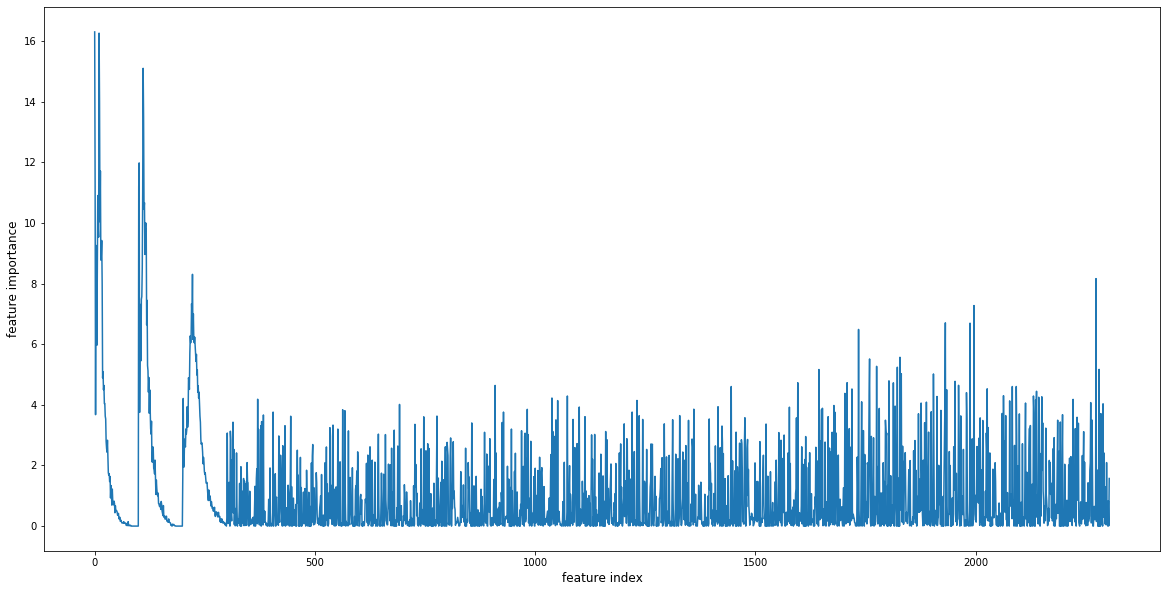

In [139]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=12)
plt.ylabel('feature importance', fontsize=12)
plt.savefig('cn_full_bm_fis.png', dpi=100)

In [140]:
plt.close()

## Adversarial controls

In [43]:
# View current training set
X_train

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.000000,0,0.078367,0.0,0,0,0.000000,0,0.000000
1,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,1,12.622999,0,0.160000,0.0,0,0,0.000000,0,0.000000
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,0.000000,0,1.054694,0.0,0,0,5.687386,0,0.000000
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.692589,0,1.725714,0.0,0,0,5.687386,0,0.000000
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,2,0.000000,0,0.933878,0.0,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,2,2.240650,0,0.852290,0.0,0,0,0.000000,0,17.075242
36497,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,4.568010,0,0.798413,0.0,0,0,0.000000,0,22.762629
36498,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,11.395192,0,0.796871,0.0,0,0,0.000000,0,39.850954
36499,78.0,49.0,67.0,50.0,61.0,67.0,40.0,83.0,67.0,51.0,...,0,0.000000,0,0.544490,0.0,0,0,0.000000,0,22.998047


### Shuffle inputs, leaving outputs the same (shuffle inputs)
Trains model on fake reactions, testing on same test set of real ones

In [44]:
# Shuffle row ordering removing index
X_train_shuffle = np.random.permutation(X_train.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_shuffle_inputs = pd.DataFrame(
    X_train_shuffle, index=X_train.index, columns=X_train.columns
)

# View new dataframe (can see inputs have changed)
X_train_shuffle_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,70.0,67.0,49.0,61.0,67.0,67.0,40.0,73.0,41.0,61.0,...,0.0,12.675033,0.0,0.160816,0.0,0.0,0.0,5.907180,0.0,0.000000
1,70.0,67.0,49.0,61.0,67.0,40.0,73.0,41.0,67.0,61.0,...,1.0,28.781797,0.0,0.391973,0.0,0.0,0.0,0.000000,0.0,11.840869
2,78.0,67.0,49.0,40.0,67.0,67.0,49.0,41.0,67.0,40.0,...,1.0,0.000000,0.0,0.627755,0.0,0.0,0.0,0.000000,0.0,0.000000
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,50.0,61.0,67.0,...,0.0,3.428578,0.0,0.276780,0.0,0.0,0.0,0.000000,0.0,5.687386
4,78.0,49.0,67.0,61.0,78.0,67.0,61.0,78.0,49.0,0.0,...,0.0,41.136569,0.0,0.653878,0.0,0.0,0.0,11.374773,0.0,5.749512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,67.0,79.0,67.0,49.0,61.0,67.0,67.0,40.0,73.0,41.0,...,1.0,0.000000,0.0,0.217188,0.0,1.0,0.0,0.000000,1.0,5.749512
36497,78.0,67.0,49.0,61.0,67.0,40.0,70.0,41.0,67.0,61.0,...,0.0,14.178427,0.0,0.182041,0.0,0.0,0.0,0.000000,0.0,0.000000
36498,78.0,49.0,67.0,61.0,67.0,67.0,61.0,67.0,49.0,0.0,...,0.0,3.070481,0.0,0.537234,0.0,0.0,0.0,5.687386,0.0,16.814289
36499,67.0,79.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,1.0,0.000000,0.0,0.398367,0.0,0.0,0.0,0.000000,0.0,5.749512


In [45]:
# But indices have stayed the same
X_train_shuffle_inputs.index

Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               10,
            ...
            36486, 36488, 36490, 36491, 36492, 36493, 36497, 36498, 36499,
            36500],
           dtype='int64', length=32386)

In [46]:
X_train.index

Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               10,
            ...
            36486, 36488, 36490, 36491, 36492, 36493, 36497, 36498, 36499,
            36500],
           dtype='int64', length=32386)

In [47]:
# Re-train and test model
start_time = time.time()
shuffle_inputs_file = 'shuffle_inputs_bm_gbm.model.joblib'
shuffle_inputs_bm_gbm = train_lgbm_classifier(
    X_train_shuffle_inputs, y_train, shuffle_inputs_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_inputs_bm_preds = shuffle_inputs_bm_gbm.predict_proba(X_test)

# Get top-k predicted rankings from prediction set
suffle_inputs_bm_preds_labeled = get_top_k_preds(
    shuffle_inputs_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_inputs_bm_formatted_results = format_results_for_metrics(
    suffle_inputs_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_inputs_bm_metrics = get_metrics_dict(
    shuffle_inputs_bm_formatted_results, type_count, 
    'shuffle_inputs_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_inputs_top_1_acc = shuffle_inputs_bm_metrics['top_1_acc']
shuffle_inputs_top_3_acc = shuffle_inputs_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 3566.5893020629883 s
Top 1 accuracy for type  M  : 0.22590529247910862
Top 3 accuracy for type  M  : 0.6286908077994429
Top 1 accuracy for type  L  : 0.5139275766016713
Top 3 accuracy for type  L  : 0.6454038997214485
Top 1 accuracy for type  B  : 0.21671309192200558
Top 3 accuracy for type  B  : 0.6077994428969359
Top 1 accuracy for type  S  : 0.2944289693593315
Top 3 accuracy for type  S  : 0.5403899721448467
Top 1 accuracy for type  A  : 0.7938718662952646
Top 3 accuracy for type  A  : 0.905849582172702


### Feature importances

In [141]:
num_estimators = len(shuffle_inputs_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_inputs_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('cn_shuffle_inputs_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['110', '10', '111', '11', '7', '109', 'product_JGI6', '13', '114', '9',
       '113', '101', '222', '12', '112', '115', 'product_JGI7', '223', '16',
       '100'],
      dtype='object')
Index(['110', '10', '111', '11', '7', '109', '13', '114', '9', '113', '222',
       '101', '12', '112', '115', '223', '16', '100', '116', '14'],
      dtype='object')
Index(['product_JGI6', 'product_JGI7', 'product_JGI4', 'product_JGI5',
       'product_JGI3', 'product_ATSC8d', 'product_JGI8', 'product_CIC3',
       'product_JGI2', 'product_ATSC8i', 'product_ATSC5i',
       'product_EState_VSA7', 'product_JGI9', 'product_ATSC7i',
       'product_ATSC4i', 'product_ATSC4dv', 'product_ATSC7p',
       'product_PEOE_VSA8', 'product_ATSC8dv', 'product_ATSC3dv'],
      dtype='object')


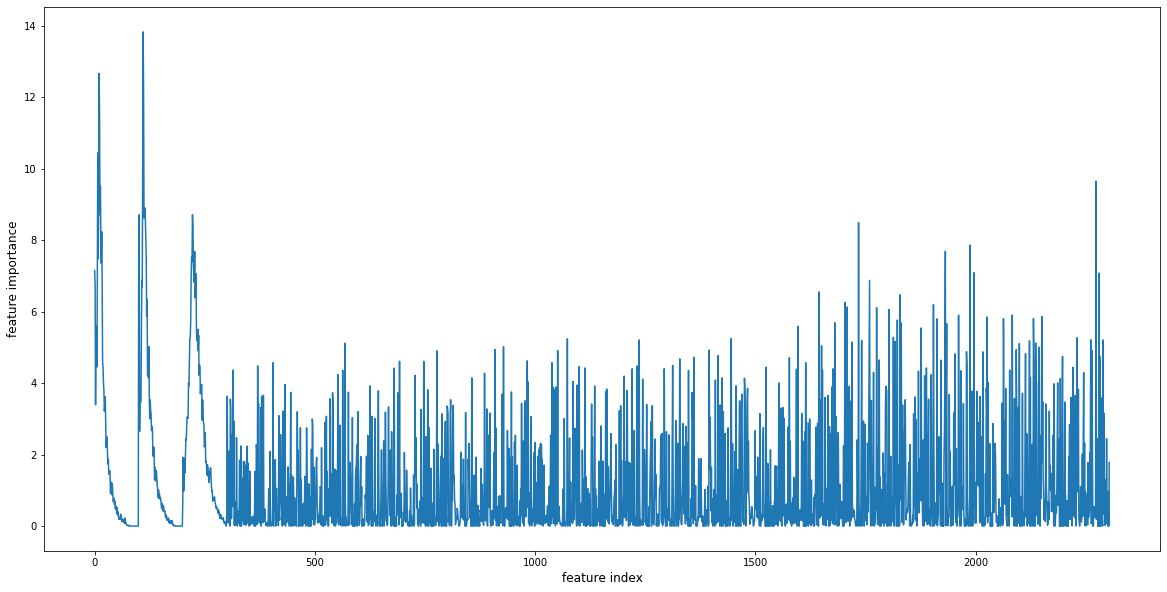

In [142]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=12)
plt.ylabel('feature importance', fontsize=12)
plt.savefig('cn_shuffle_inputs_bm_fis.png', dpi=100)

In [143]:
plt.close()

### Ablate SMILES region (Mordred only)

In [51]:
# Create new dataframe from only the Mordred input region
X_train_mordred = X_train[X_train.columns[300:]].copy()
X_test_mordred = X_test[X_test.columns[300:]].copy()
print(X_test_mordred.shape)

# View new dataframe (can see inputs have changed)
X_train_mordred

(3590, 2004)


,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,4,5.151435e-14,3.248435,0,0,0.000000,1824.920267,0.0,3.962406e-01,-5.273559e-16,...,0,0.000000,0,0.078367,0.0,0,0,0.000000,0,0.000000
1,3,8.988986e+00,1.945910,0,0,0.000000,2778.834070,0.0,2.250000e+00,-4.483640e-01,...,1,12.622999,0,0.160000,0.0,0,0,0.000000,0,0.000000
2,5,-3.553735e+00,3.812203,0,0,9.495353,2205.387025,0.0,-1.332268e-15,7.105766e-01,...,0,0.000000,0,1.054694,0.0,0,0,5.687386,0,0.000000
3,4,-1.080025e-12,3.409496,0,0,0.000000,1749.231451,0.0,0.000000e+00,-6.245005e-16,...,0,0.692589,0,1.725714,0.0,0,0,5.687386,0,0.000000
4,10,4.170063e+01,4.290459,0,0,4.895483,4425.946139,0.0,6.037853e-01,5.718414e-01,...,2,0.000000,0,0.933878,0.0,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,8,1.024338e+02,4.861749,0,0,0.000000,4930.648221,0.0,2.110902e-01,5.068421e-01,...,2,2.240650,0,0.852290,0.0,0,0,0.000000,0,17.075242
36497,10,2.457235e+01,4.963718,1,0,0.000000,5375.068238,0.0,3.888469e-01,-2.241072e-01,...,0,4.568010,0,0.798413,0.0,0,0,0.000000,0,22.762629
36498,10,2.498193e+01,4.945207,0,0,17.473213,6024.814665,0.0,1.299257e+00,-2.227146e-01,...,0,11.395192,0,0.796871,0.0,0,0,0.000000,0,39.850954
36499,4,2.557954e-13,3.457893,0,0,0.000000,1777.825008,0.0,1.666667e-01,-9.887924e-17,...,0,0.000000,0,0.544490,0.0,0,0,0.000000,0,22.998047


In [52]:
# Re-train and test model
start_time = time.time()
mordred_only_file = 'mordred_only_bm_gbm.model.joblib'
mordred_only_bm_gbm = train_lgbm_classifier(
    X_train_mordred, y_train, mordred_only_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
mordred_only_preds = mordred_only_bm_gbm.predict_proba(X_test_mordred)

# Get top-k predicted rankings from prediction set
mordred_only_preds_labeled = get_top_k_preds(
    mordred_only_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
mordred_only_formatted_results = format_results_for_metrics(
    mordred_only_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
mordred_only_metrics = get_metrics_dict(
    mordred_only_formatted_results, type_count, 'mordred_only_metrics.json'
)

# View top-1 and top-3 accuracy metrics
mordred_only_top_1_acc = mordred_only_metrics['top_1_acc']
mordred_only_top_3_acc = mordred_only_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 3017.2903010845184 s
Top 1 accuracy for type  M  : 0.36016713091922004
Top 3 accuracy for type  M  : 0.707799442896936
Top 1 accuracy for type  L  : 0.5350974930362117
Top 3 accuracy for type  L  : 0.7401114206128133
Top 1 accuracy for type  B  : 0.37771587743732593
Top 3 accuracy for type  B  : 0.7105849582172702
Top 1 accuracy for type  S  : 0.3593314763231198
Top 3 accuracy for type  S  : 0.6392757660167131
Top 1 accuracy for type  A  : 0.766016713091922
Top 3 accuracy for type  A  : 0.922841225626741


### Feature importances

In [144]:
num_estimators = len(mordred_only_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(mordred_only_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
mordred_only_average_fis = np.average(np.array(all_fis), axis=0)
sorted_mordred_only_fis = np.argsort(-mordred_only_average_fis)
mordred_only_fi_names = X_train_mordred.columns[sorted_mordred_only_fis]

mordred_only_fi_df = pd.DataFrame(
    list(zip(mordred_only_fi_names, 
             mordred_only_average_fis[sorted_mordred_only_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_only_fi_df.to_csv('cn_mordred_only_fis.csv')

top_mordred_only_fis = sorted_mordred_only_fis[:20]

top_mordred_only_fi_names = X_train_mordred.columns[top_mordred_only_fis]

print(top_mordred_only_fi_names)

Index(['product_JGI6', 'product_JGI3', 'product_JGI7', 'product_JGI4',
       'product_JGI5', 'product_JGI2', 'product_CIC3', 'product_JGI8',
       'product_ATSC5i', 'product_PEOE_VSA8', 'product_ATSC7i',
       'product_ATSC8d', 'product_ATSC6d', 'product_JGI9', 'product_ATSC2dv',
       'product_ATSC8i', 'product_JGI10', 'product_ATSC4dv', 'product_ATSC3dv',
       'product_ATSC4i'],
      dtype='object')


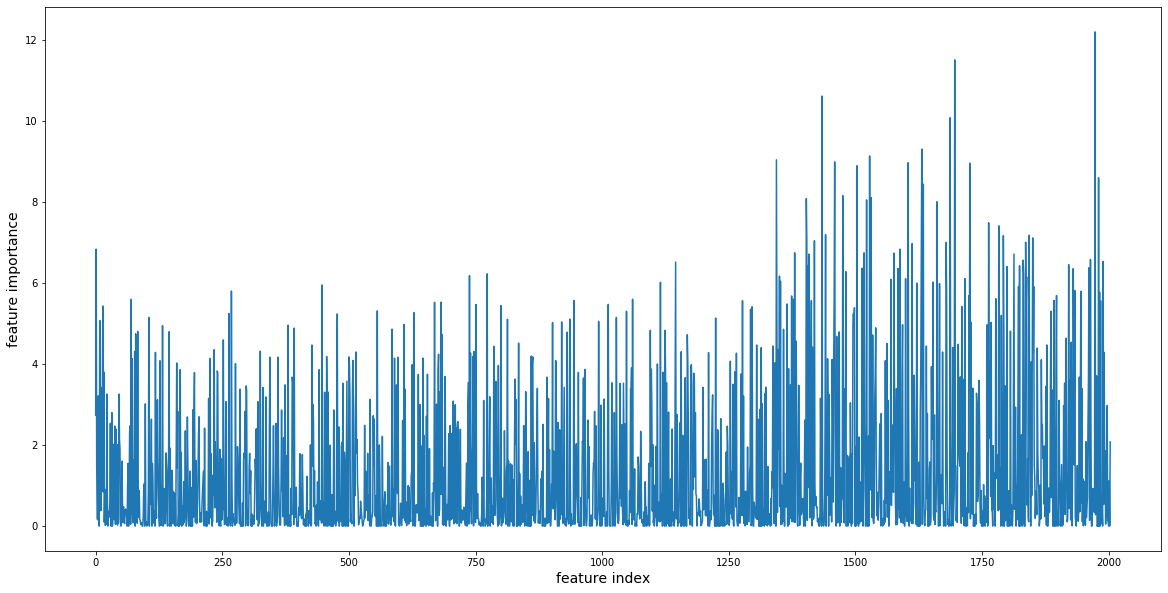

In [145]:
plt.figure(num=None, figsize=(20,10))
plt.plot(mordred_only_average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_mordred_only_bm_fis.png', dpi=100)

In [146]:
plt.close()

## Feature selection

In [56]:
# Choose top-100 FIs to re-train slim model
selected_features = np.argsort(-average_fis)[:100]
selected_columns = X_train_mordred.columns[selected_features]
X_train_mordred_feat_sel = X_train_mordred[list(selected_columns)]
X_test_mordred_feat_sel = X_test_mordred[list(selected_columns)]
X_train_mordred_feat_sel

,product_JGI6,product_JGI3,product_JGI7,product_JGI4,product_JGI5,product_JGI2,product_CIC3,product_JGI8,product_ATSC5i,product_PEOE_VSA8,...,rdfred_2_ATSC5Z,rdfred_1_ATSC5dv,product_ATSC2v,rdfred_2_ATSC5p,product_SaasC,rdfred_2_ATSC3i,rdfred_1_ATSC3v,product_EState_VSA6,rdfred_2_ATSC3p,product_EState_VSA5
0,0.009796,0.026786,0.012153,0.030222,0.001389,0.026144,1.312907,0.000000,10.366791,11.374773,...,18.367347,7.311385,-522.285303,0.787375,2.238333,-10.715496,-172.540955,0.000000,-1.771785,0.000000
1,0.026667,0.027344,0.015625,0.023030,0.027778,0.074074,0.769231,0.020408,-1.452149,31.866412,...,134.750000,9.000000,-155.054687,-2.213643,0.946097,-4.581998,-175.584070,0.000000,-3.529570,12.132734
2,0.029297,0.076250,0.022569,0.045641,0.027623,0.121212,0.614565,0.018202,12.202025,26.371697,...,-117.557656,-24.571401,91.039559,-2.666892,-0.633600,-14.755267,-244.425775,0.000000,-1.868505,36.398202
3,0.039221,0.113147,0.010772,0.027884,0.034564,0.106667,0.875900,0.021449,-13.077495,28.563300,...,32.938776,7.976900,519.203890,-0.726140,-0.242670,-29.378278,-419.177217,24.265468,-5.805502,0.000000
4,0.017294,0.056713,0.018976,0.037737,0.039570,0.092929,1.358517,0.014085,33.412593,44.194544,...,-155.224766,-2.558431,1035.628431,4.124166,2.325110,-3.222141,-399.758920,10.966277,-2.879625,23.894619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,0.010522,0.042907,0.010373,0.041938,0.016422,0.057057,0.755683,0.007874,7.283367,32.926035,...,-20.112653,-62.704861,-598.532016,1.827118,12.057782,-13.304447,143.956767,0.000000,-1.177615,15.478353
36497,0.011741,0.047135,0.011144,0.035014,0.018185,0.060883,0.679840,0.009462,7.742921,48.693580,...,-158.622268,-71.699255,-413.593367,-4.653509,4.265622,7.791273,-57.351301,0.000000,0.864561,41.847662
36498,0.010769,0.038870,0.005298,0.025746,0.021893,0.058824,1.125815,0.006018,22.001213,33.150189,...,-4.580340,-37.191982,-580.157806,-0.529682,5.743536,-7.920467,-282.569409,0.000000,0.469855,11.728187
36499,0.020166,0.032895,0.013310,0.057778,0.019636,0.072072,0.514286,0.011007,18.801549,17.028218,...,54.360000,7.501111,-398.593139,2.299510,5.640226,-13.034641,90.150739,0.000000,-1.458026,0.000000


In [57]:
X_test_mordred_feat_sel

,product_JGI6,product_JGI3,product_JGI7,product_JGI4,product_JGI5,product_JGI2,product_CIC3,product_JGI8,product_ATSC5i,product_PEOE_VSA8,...,rdfred_2_ATSC5Z,rdfred_1_ATSC5dv,product_ATSC2v,rdfred_2_ATSC5p,product_SaasC,rdfred_2_ATSC3i,rdfred_1_ATSC3v,product_EState_VSA6,rdfred_2_ATSC3p,product_EState_VSA5
5,0.021953,0.047619,0.013021,0.031667,0.031344,0.081301,0.287744,0.010700,-18.127385,33.953644,...,-4.612245,-9.737257,346.236537,-1.384181,2.092144,-5.757966,-395.420125,30.723265,-0.330205,25.308899
32,0.023987,0.059309,0.019432,0.050122,0.031528,0.101010,0.190196,0.015571,0.762884,23.467298,...,-215.250000,1.280000,-303.729038,-1.790515,0.115463,-4.117686,-197.132151,24.526421,-3.692592,4.567100
70,0.003785,0.034722,0.006076,0.035873,0.020833,0.055556,0.742155,0.008062,4.333324,11.729227,...,-12.620000,7.396173,-353.892075,-0.597548,2.467783,-5.659298,-203.871058,0.000000,-1.188032,5.563451
72,0.003785,0.034722,0.006076,0.035873,0.020833,0.055556,0.742155,0.008062,4.333324,11.729227,...,-12.620000,7.396173,-353.892075,-0.597548,2.467783,-5.659298,-203.871058,0.000000,-1.188032,5.563451
78,0.020408,0.047794,0.015625,0.036239,0.030934,0.086420,0.808822,0.020408,20.891836,5.687386,...,-51.040000,7.396173,-126.331255,0.844489,0.785741,-13.966032,-203.871058,0.000000,-2.408419,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36473,0.006628,0.042254,0.009893,0.037310,0.010456,0.055556,1.520599,0.009403,-7.122602,15.478353,...,-0.245747,-9.286704,-662.357012,-0.115724,10.903973,2.639658,-91.659618,0.000000,-0.498019,54.565755
36476,0.011888,0.029851,0.005980,0.032274,0.021940,0.060932,1.429143,0.006047,19.689335,32.168708,...,22.019724,-9.286704,-634.540932,3.689727,10.785477,-41.569226,-91.659618,0.000000,-3.116558,21.165740
36487,0.015469,0.033654,0.010471,0.047660,0.012379,0.060185,0.655773,0.008809,1.138739,15.478353,...,51.222222,-9.286704,-328.921733,1.694408,6.264145,-8.744146,-91.659618,0.000000,-2.907580,48.398023
36494,0.014017,0.049769,0.012784,0.034483,0.017634,0.057613,0.477995,0.007885,-1.865040,31.932203,...,-94.280000,7.311385,-178.852702,-1.663772,1.175265,-3.492511,-172.540955,17.664106,0.733824,42.965604


In [58]:
# Re-train and test model
start_time = time.time()
mordred_feat_sel_file = 'mordred_feat_sel_bm_gbm.model.joblib'
mordred_feat_sel_bm_gbm = train_lgbm_classifier(
    X_train_mordred_feat_sel, y_train, mordred_feat_sel_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
mordred_feat_sel_preds = mordred_feat_sel_bm_gbm.predict_proba(
    X_test_mordred_feat_sel
)

# Get top-k predicted rankings from prediction set
mordred_feat_sel_preds_labeled = get_top_k_preds(
    mordred_feat_sel_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
mordred_feat_sel_formatted_results = format_results_for_metrics(
    mordred_feat_sel_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
mordred_feat_sel_metrics = get_metrics_dict(
    mordred_feat_sel_formatted_results, type_count, 
    'mordred_feat_sel_metrics.json'
)

# View top-1 and top-3 accuracy metrics
mordred_feat_sel_top_1_acc = mordred_feat_sel_metrics['top_1_acc']
mordred_feat_sel_top_3_acc = mordred_feat_sel_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 225.29196691513062 s
Top 1 accuracy for type  M  : 0.3501392757660167
Top 3 accuracy for type  M  : 0.7047353760445683
Top 1 accuracy for type  L  : 0.5314763231197771
Top 3 accuracy for type  L  : 0.7364902506963789
Top 1 accuracy for type  B  : 0.37715877437325906
Top 3 accuracy for type  B  : 0.7061281337047354
Top 1 accuracy for type  S  : 0.3540389972144847
Top 3 accuracy for type  S  : 0.6473537604456825
Top 1 accuracy for type  A  : 0.7860724233983287
Top 3 accuracy for type  A  : 0.9242339832869081


### Feature importances

In [151]:
num_estimators = len(mordred_feat_sel_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(mordred_feat_sel_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
sorted_fis = np.argsort(-average_fis)
mordred_fi_names = X_train_mordred_feat_sel.columns[sorted_fis]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, average_fis[sorted_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('cn_mordred_feat_sel_bm_fis.csv')

top_fis = sorted_fis[:20]

top_fi_names = X_train_mordred_feat_sel.columns[top_fis]

print(top_fi_names)

Index(['rdfred_1_ATSC1m', 'rdfred_1_ATSC5i', 'rdfred_1_ATSC3v',
       'rdfred_1_ATSC4v', 'rdfred_1_ATSC5dv', 'rdfred_1_ATSC4i',
       'product_JGI6', 'product_JGI3', 'rdfred_2_ATSC1m', 'product_fMF',
       'product_ZMIC3', 'product_JGI4', 'product_ATSC2dv', 'product_ATSC1se',
       'rdfred_2_ATSC6m', 'product_AATSC0p', 'rdfred_2_ATSC4se',
       'product_JGI7', 'product_MIC1', 'product_CIC3'],
      dtype='object')


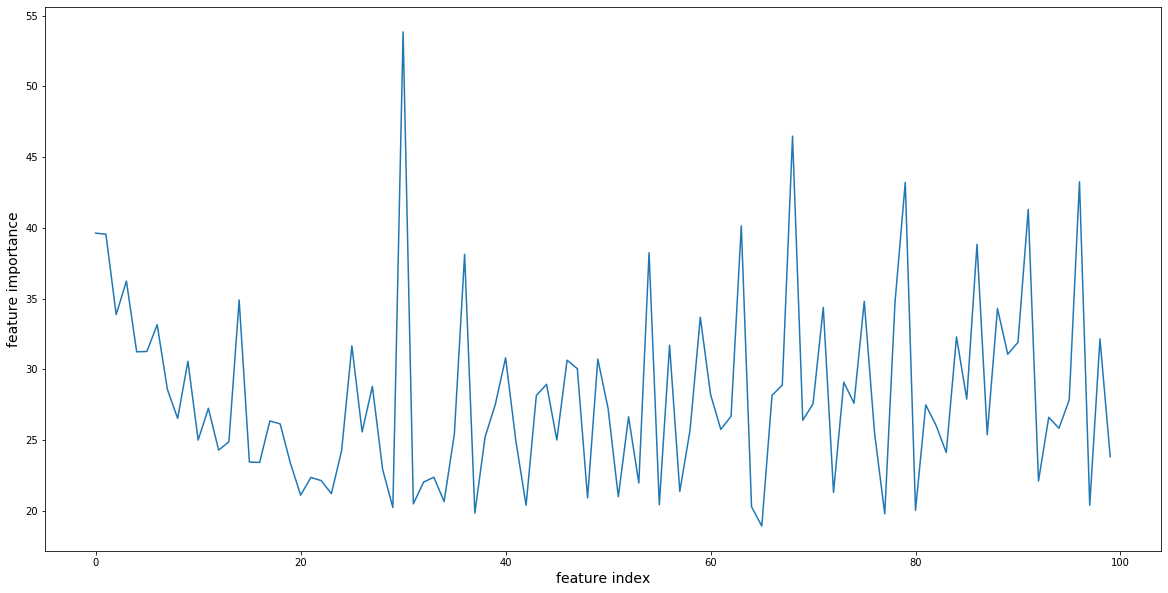

In [152]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_mordred_feat_sel_bm_fis.png', dpi=100)

In [153]:
plt.close()

## Inverse feature selection (i.e., feature ablation)
Remove top-100 Mordred features

In [67]:
# Remove top-100 FIs to re-train slim model
selected_features_abl = np.argsort(-mordred_only_average_fis)[100:]
selected_columns_abl = X_train_mordred.columns[selected_features_abl]
X_train_mordred_feat_abl = X_train_mordred[list(selected_columns_abl)]
X_test_mordred_feat_abl = X_test_mordred[list(selected_columns_abl)]
X_train_mordred_feat_abl

,rdfred_1_ATSC5p,product_ATSC1pe,rdfred_1_AATSC0i,rdfred_1_ATSC4p,product_ATSC6pe,rdfred_1_ATSC5v,rdfred_2_JGI3,rdfred_2_ATSC3v,rdfred_2_ATSC5i,rdfred_2_ATSC1i,...,product_NsssP,product_NaaSe,rdfred_1_n8Ring,rdfred_1_SssSiH2,rdfred_2_NssssSn,product_NssSiH2,rdfred_2_n11FaHRing,rdfred_2_NsSH,rdfred_1_NaaSe,rdfred_1_SsssB
0,-0.197874,-0.014700,1.262294,-0.946613,-0.107800,62.851267,0.037500,-392.558762,4.373530,6.123503e+00,...,0,0,0,0,0,0,0,0,0,0.0
1,0.836965,-0.003402,1.257530,-0.293761,0.800254,225.357266,0.035714,-264.175332,-7.568595,-6.883383e-15,...,0,0,0,0,0,0,0,0,0,0.0
2,1.747984,0.808865,1.440533,-4.204612,0.815508,199.391854,0.097656,-368.740139,-3.888694,5.724205e+00,...,0,0,0,0,0,0,0,0,0,0.0
3,-4.138339,0.849442,1.327686,2.838684,-0.764888,-154.097713,0.131649,-1217.321773,-17.501480,1.017001e+01,...,0,0,0,0,0,0,0,0,0,0.0
4,-1.008989,0.418183,1.415540,-5.806655,-0.185628,-208.889996,0.066964,-837.368359,38.714686,-1.893925e+01,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,-3.883821,0.397230,1.737518,0.468741,-1.771313,-523.812893,0.045833,-57.351301,24.964233,-7.078756e+00,...,0,0,0,0,0,0,0,0,0,0.0
36497,0.468690,0.337606,1.503992,0.240762,-0.817874,19.037527,0.052083,216.357543,-17.734195,5.821860e+00,...,0,0,0,0,0,0,0,0,0,0.0
36498,0.338860,0.293376,1.572968,3.030841,-2.080822,296.245493,0.049679,15.235917,-0.956878,-8.021634e+00,...,0,0,0,0,0,0,0,0,0,0.0
36499,-3.198975,-0.075093,1.390041,-6.399258,-0.460876,-115.480490,0.033654,-260.976769,12.704438,4.075596e+00,...,0,0,0,0,0,0,0,1,0,0.0


In [68]:
X_test_mordred_feat_abl

,rdfred_1_ATSC5p,product_ATSC1pe,rdfred_1_AATSC0i,rdfred_1_ATSC4p,product_ATSC6pe,rdfred_1_ATSC5v,rdfred_2_JGI3,rdfred_2_ATSC3v,rdfred_2_ATSC5i,rdfred_2_ATSC1i,...,product_NsssP,product_NaaSe,rdfred_1_n8Ring,rdfred_1_SssSiH2,rdfred_2_NssssSn,product_NssSiH2,rdfred_2_n11FaHRing,rdfred_2_NsSH,rdfred_1_NaaSe,rdfred_1_SsssB
5,-2.432031,-0.011865,1.317054,-3.237734,-1.202484,-81.673587,0.035156,-111.497251,-20.247411,-7.185275e+00,...,0,0,0,0,0,0,0,0,0,0.0
32,-0.601955,0.168497,1.734064,-0.295372,-0.171061,-125.009473,0.071429,-203.871058,1.641496,1.465494e-14,...,0,0,0,0,0,0,0,0,0,0.0
70,-1.790515,0.009168,1.510128,-3.655405,-0.007905,22.433502,0.048611,-283.271641,-4.281953,5.817375e+00,...,0,0,0,0,0,0,0,0,0,0.0
72,-1.790515,0.009168,1.510128,-3.655405,-0.007905,22.433502,0.048611,-283.271641,-4.281953,5.817375e+00,...,0,0,0,0,0,0,0,0,0,0.0
78,-1.790515,-0.270807,1.510128,-3.655405,-0.422751,22.433502,0.062500,-525.025673,6.388810,3.000842e+00,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36473,-1.254814,0.241203,1.603885,-3.503690,-1.595200,-101.875549,0.043155,27.595035,0.922149,2.868204e+00,...,0,0,0,0,0,0,0,0,0,0.0
36476,-1.254814,0.290354,1.603885,-3.503690,-1.331112,-101.875549,0.021382,-282.569409,23.290623,-7.190709e+00,...,0,0,0,0,0,0,0,0,0,0.0
36487,-1.254814,0.194676,1.603885,-3.503690,-0.527737,-101.875549,0.029891,-464.087862,5.612571,1.619518e+00,...,0,0,0,0,0,0,0,0,0,0.0
36494,-0.197874,0.207500,1.262294,-0.946613,-0.044344,62.851267,0.046838,38.482477,-4.085339,4.827629e-01,...,0,0,0,0,0,0,0,0,0,0.0


In [69]:
# Re-train and test model
start_time = time.time()
mordred_feat_abl_file = 'mordred_feat_abl_bm_gbm.model.joblib'
mordred_feat_abl_bm_gbm = train_lgbm_classifier(
    X_train_mordred_feat_abl, y_train, mordred_feat_abl_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
mordred_feat_abl_preds = mordred_feat_abl_bm_gbm.predict_proba(
    X_test_mordred_feat_abl
)

# Get top-k predicted rankings from prediction set
mordred_feat_abl_preds_labeled = get_top_k_preds(
    mordred_feat_abl_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
mordred_feat_abl_formatted_results = format_results_for_metrics(
    mordred_feat_abl_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
mordred_feat_abl_metrics = get_metrics_dict(
    mordred_feat_abl_formatted_results, type_count, 
    'mordred_feat_abl_metrics.json'
)

# View top-1 and top-3 accuracy metrics
mordred_feat_abl_top_1_acc = mordred_feat_abl_metrics['top_1_acc']
mordred_feat_abl_top_3_acc = mordred_feat_abl_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 2494.762013912201 s
Top 1 accuracy for type  M  : 0.362116991643454
Top 3 accuracy for type  M  : 0.7069637883008356
Top 1 accuracy for type  L  : 0.5267409470752089
Top 3 accuracy for type  L  : 0.735933147632312
Top 1 accuracy for type  B  : 0.3766016713091922
Top 3 accuracy for type  B  : 0.7086350974930362
Top 1 accuracy for type  S  : 0.3557103064066852
Top 3 accuracy for type  S  : 0.6403899721448468
Top 1 accuracy for type  A  : 0.7952646239554317
Top 3 accuracy for type  A  : 0.9256267409470752


### Feature importances

In [154]:
num_estimators = len(mordred_feat_abl_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(mordred_feat_abl_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
sorted_fis = np.argsort(-average_fis)
mordred_fi_names = X_train_mordred_feat_abl.columns[sorted_fis]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, average_fis[sorted_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('cn_mordred_feat_abl_bm_fis.csv')

top_fis = sorted_fis[:20]

top_fi_names = X_train_mordred_feat_abl.columns[top_fis]

print(top_fi_names)

Index(['product_ATSC7Z', 'rdfred_2_ATSC5m', 'rdfred_1_ATSC5p', 'product_CIC5',
       'product_ATSC7are', 'product_ATSC1pe', 'product_ATSC6pe',
       'rdfred_2_ATSC5i', 'rdfred_2_ATSC6Z', 'product_ATSC5are',
       'product_ATSC8pe', 'product_MIC2', 'product_ATSC5Z', 'product_ATSC6m',
       'product_BalabanJ', 'rdfred_2_ATSC3v', 'product_ATSC6are',
       'rdfred_1_ATSC4p', 'product_ATSC4pe', 'product_ATSC8are'],
      dtype='object')


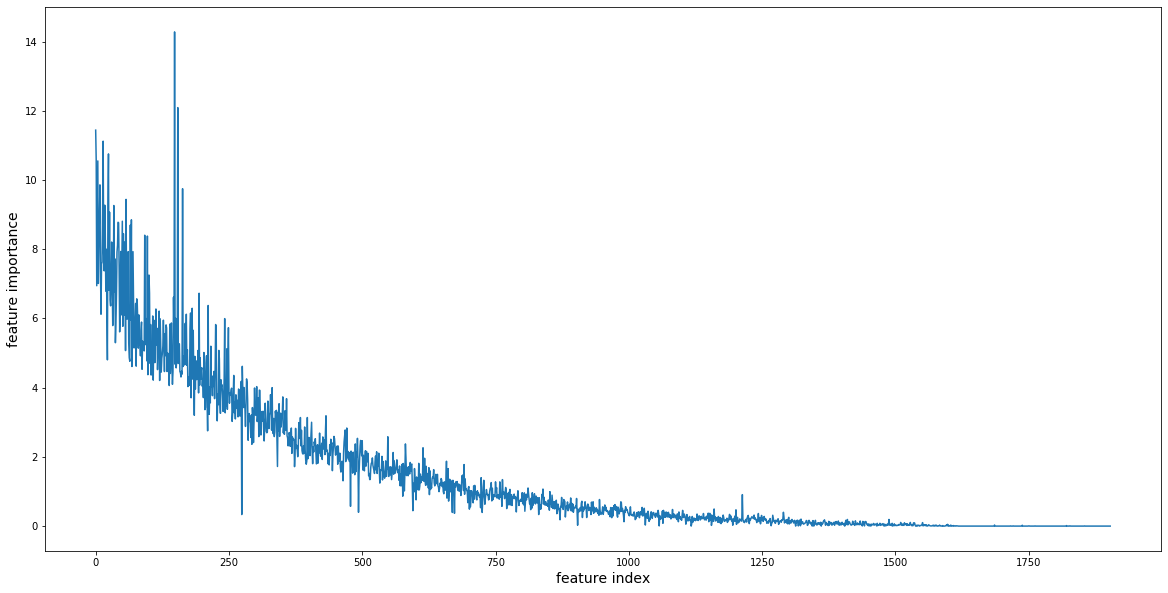

In [155]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_mordred_feat_abl_bm_fis.png', dpi=100)

In [156]:
plt.close()

## Randomized Mordred vectors (random Mordred)
A random "barcode" is written for each unique molecule's Mordred vector drawing from a standard normal distribution. Essentially removes any continuity between chemical space, only identifying the unique molecules in a reaction.

In [75]:
X_train_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,4,5.151435e-14,3.248435,0,0,0.000000,1824.920267,0.0,3.962406e-01,-5.273559e-16,...,0,0.000000,0,0.078367,0.0,0,0,0.000000,0,0.000000
1,3,8.988986e+00,1.945910,0,0,0.000000,2778.834070,0.0,2.250000e+00,-4.483640e-01,...,1,12.622999,0,0.160000,0.0,0,0,0.000000,0,0.000000
2,5,-3.553735e+00,3.812203,0,0,9.495353,2205.387025,0.0,-1.332268e-15,7.105766e-01,...,0,0.000000,0,1.054694,0.0,0,0,5.687386,0,0.000000
3,4,-1.080025e-12,3.409496,0,0,0.000000,1749.231451,0.0,0.000000e+00,-6.245005e-16,...,0,0.692589,0,1.725714,0.0,0,0,5.687386,0,0.000000
4,10,4.170063e+01,4.290459,0,0,4.895483,4425.946139,0.0,6.037853e-01,5.718414e-01,...,2,0.000000,0,0.933878,0.0,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,8,1.024338e+02,4.861749,0,0,0.000000,4930.648221,0.0,2.110902e-01,5.068421e-01,...,2,2.240650,0,0.852290,0.0,0,0,0.000000,0,17.075242
36497,10,2.457235e+01,4.963718,1,0,0.000000,5375.068238,0.0,3.888469e-01,-2.241072e-01,...,0,4.568010,0,0.798413,0.0,0,0,0.000000,0,22.762629
36498,10,2.498193e+01,4.945207,0,0,17.473213,6024.814665,0.0,1.299257e+00,-2.227146e-01,...,0,11.395192,0,0.796871,0.0,0,0,0.000000,0,39.850954
36499,4,2.557954e-13,3.457893,0,0,0.000000,1777.825008,0.0,1.666667e-01,-9.887924e-17,...,0,0.000000,0,0.544490,0.0,0,0,0.000000,0,22.998047


In [172]:
mordred_max = X_full_mordred.max().max()
mordred_max

449956.0

In [77]:
# Get all unique Mordred vectors from dataset
# Separate molecules
X_full_mordred = pd.DataFrame(
    X_full[X_full.columns[300:]].copy().values, 
    index=X_full.index.values
)
reactant_1_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[:668]].copy().values, 
    index=X_full.index.values
)
reactant_2_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[668:1336]].copy().values, 
    index=X_full.index.values
)
product_mordred = pd.DataFrame(
    X_full_mordred[X_full_mordred.columns[1336:]].copy().values, 
    index=X_full.index.values
)

# Join tabulated vectors to single lists
for df in [reactant_1_mordred, reactant_2_mordred, product_mordred]:
    df['joined'] = df.values.tolist()
    df['str_joined'] = df['joined'].astype('str')

# Create dataframe with all unique SMILES from the dataset
unique_mordred = pd.concat(
    [reactant_1_mordred, reactant_2_mordred, product_mordred],
    ignore_index=True
)
print(f'Total Mordred vectors: {len(unique_mordred)}')
unique_mordred = unique_mordred.drop_duplicates(subset=['str_joined'])
print(f'Unique Mordred vectors: {len(unique_mordred)}')

# Create random fake vector representations for all unique molecules
unique_mordred['random'] = [
    (np.random.rand(668)*mordred_max).tolist() 
    for _ in range(len(unique_mordred))
]
unique_mordred['str_random'] = unique_mordred['random'].astype('str')
unique_mordred

Total Mordred vectors: 107928
Unique Mordred vectors: 32429


,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,random,str_random
0,4.0,5.151435e-14,3.248435,0.0,0.0,0.000000,1824.920267,0.0,3.962406e-01,-5.273559e-16,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, 5.1514348342607263e-14, 3.24843462710974...","[4.0, 5.1514348342607263e-14, 3.24843462710974...","[431223.0283020679, 206347.95749181692, 58099....","[431223.0283020679, 206347.95749181692, 58099...."
1,3.0,8.988986e+00,1.945910,0.0,0.0,0.000000,2778.834070,0.0,2.250000e+00,-4.483640e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[3.0, 8.988985999999926, 1.9459101490553128, 0...","[3.0, 8.988985999999926, 1.9459101490553128, 0...","[355981.52359541017, 323976.52870443574, 41805...","[355981.52359541017, 323976.52870443574, 41805..."
2,5.0,-3.553735e+00,3.812203,0.0,0.0,9.495353,2205.387025,0.0,-1.332268e-15,7.105766e-01,...,0.0,0.0,0.0,5.687386,0.0,0.000000,"[5.0, -3.5537354285714, 3.8122026701459353, 0....","[5.0, -3.5537354285714, 3.8122026701459353, 0....","[204286.2181188628, 19545.010884032487, 336383...","[204286.2181188628, 19545.010884032487, 336383..."
3,4.0,-1.080025e-12,3.409496,0.0,0.0,0.000000,1749.231451,0.0,0.000000e+00,-6.245005e-16,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, -1.0800249583553525e-12, 3.4094961844768...","[4.0, -1.0800249583553525e-12, 3.4094961844768...","[144897.38447648817, 95694.39858080442, 255000...","[144897.38447648817, 95694.39858080442, 255000..."
4,10.0,4.170063e+01,4.290459,0.0,0.0,4.895483,4425.946139,0.0,6.037853e-01,5.718414e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[10.0, 41.70063287277071, 4.290459441148391, 0...","[10.0, 41.70063287277071, 4.290459441148391, 0...","[434205.01791850064, 402285.9186382345, 182638...","[434205.01791850064, 402285.9186382345, 182638..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107923,16.0,1.950100e+02,5.528933,2.0,0.0,0.000000,8655.417672,0.0,1.136051e+00,4.873291e-01,...,0.0,0.0,0.0,0.000000,0.0,5.687386,"[16.0, 195.009975, 5.528932932700949, 2.0, 0.0...","[16.0, 195.009975, 5.528932932700949, 2.0, 0.0...","[105297.378741877, 440243.4424291774, 74353.40...","[105297.378741877, 440243.4424291774, 74353.40..."
107924,18.0,2.071951e+02,5.842094,2.0,0.0,0.000000,9685.547168,0.0,6.798402e-01,4.873494e-01,...,0.0,0.0,0.0,0.000000,0.0,22.762629,"[18.0, 207.1950789999997, 5.842094090453713, 2...","[18.0, 207.1950789999997, 5.842094090453713, 2...","[302555.26437771495, 212472.1328719301, 244062...","[302555.26437771495, 212472.1328719301, 244062..."
107925,15.0,2.554046e+02,5.704615,2.0,0.0,17.473213,9257.336976,0.0,1.125815e+00,-1.462911e+00,...,0.0,0.0,0.0,0.000000,0.0,39.850954,"[15.0, 255.40462263194414, 5.704615460960093, ...","[15.0, 255.40462263194414, 5.704615460960093, ...","[61607.13689012536, 191777.99253070413, 354569...","[61607.13689012536, 191777.99253070413, 354569..."
107926,12.0,-1.555616e+02,4.801970,0.0,0.0,28.020681,5358.942103,0.0,5.142857e-01,-8.658107e-01,...,0.0,0.0,0.0,0.000000,0.0,22.998047,"[12.0, -155.56159536897948, 4.801969761962699,...","[12.0, -155.56159536897948, 4.801969761962699,...","[95698.82292561166, 73635.16686247099, 408264....","[95698.82292561166, 73635.16686247099, 408264...."


In [78]:
# Create mapping from true vectors to random vectors
mordred_random_dict = dict(zip(unique_mordred['str_joined'], unique_mordred['str_random']))
len(mordred_random_dict)

32429

In [79]:
# Apply mapping to all SMILES from the dataset
for df in [reactant_1_mordred, reactant_2_mordred, product_mordred]:
    df['str_random'] = df['str_joined'].map(mordred_random_dict)
    df['random'] = [json.loads(_) for _ in df['str_random']]
reactant_1_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,4.0,5.151435e-14,3.248435,0.0,0.0,0.000000,1824.920267,0.0,3.962406e-01,-5.273559e-16,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, 5.1514348342607263e-14, 3.24843462710974...","[4.0, 5.1514348342607263e-14, 3.24843462710974...","[431223.0283020679, 206347.95749181692, 58099....","[431223.0283020679, 206347.95749181692, 58099...."
1,3.0,8.988986e+00,1.945910,0.0,0.0,0.000000,2778.834070,0.0,2.250000e+00,-4.483640e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[3.0, 8.988985999999926, 1.9459101490553128, 0...","[3.0, 8.988985999999926, 1.9459101490553128, 0...","[355981.52359541017, 323976.52870443574, 41805...","[355981.52359541017, 323976.52870443574, 41805..."
2,5.0,-3.553735e+00,3.812203,0.0,0.0,9.495353,2205.387025,0.0,-1.332268e-15,7.105766e-01,...,0.0,0.0,0.0,5.687386,0.0,0.000000,"[5.0, -3.5537354285714, 3.8122026701459353, 0....","[5.0, -3.5537354285714, 3.8122026701459353, 0....","[204286.2181188628, 19545.010884032487, 336383...","[204286.2181188628, 19545.010884032487, 336383..."
3,4.0,-1.080025e-12,3.409496,0.0,0.0,0.000000,1749.231451,0.0,0.000000e+00,-6.245005e-16,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, -1.0800249583553525e-12, 3.4094961844768...","[4.0, -1.0800249583553525e-12, 3.4094961844768...","[144897.38447648817, 95694.39858080442, 255000...","[144897.38447648817, 95694.39858080442, 255000..."
4,10.0,4.170063e+01,4.290459,0.0,0.0,4.895483,4425.946139,0.0,6.037853e-01,5.718414e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[10.0, 41.70063287277071, 4.290459441148391, 0...","[10.0, 41.70063287277071, 4.290459441148391, 0...","[434205.01791850064, 402285.9186382345, 182638...","[434205.01791850064, 402285.9186382345, 182638..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,9.0,2.213268e+01,4.582413,0.0,0.0,0.000000,5221.951471,0.0,1.169836e+00,-1.407090e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[9.0, 22.13267578027667, 4.582413198865474, 0....","[9.0, 22.13267578027667, 4.582413198865474, 0....","[305653.2642629899, 305361.38146228384, 438947...","[305653.2642629899, 305361.38146228384, 438947..."
36497,10.0,2.457235e+01,4.963718,1.0,0.0,0.000000,5375.068238,0.0,3.888469e-01,-2.241072e-01,...,0.0,0.0,0.0,0.000000,0.0,17.075242,"[10.0, 24.572351402449023, 4.963718374308504, ...","[10.0, 24.572351402449023, 4.963718374308504, ...","[169979.72948217898, 193379.26670653088, 23701...","[169979.72948217898, 193379.26670653088, 23701..."
36498,10.0,2.498193e+01,4.945207,0.0,0.0,17.473213,6024.814665,0.0,1.299257e+00,-2.227146e-01,...,0.0,0.0,0.0,0.000000,0.0,34.163568,"[10.0, 24.98193058185427, 4.945207488773801, 0...","[10.0, 24.98193058185427, 4.945207488773801, 0...","[124100.10453754602, 15827.306134454748, 7465....","[124100.10453754602, 15827.306134454748, 7465...."
36499,4.0,2.557954e-13,3.457893,0.0,0.0,0.000000,1777.825008,0.0,1.666667e-01,-9.887924e-17,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, 2.557953848736361e-13, 3.457892725338701...","[4.0, 2.557953848736361e-13, 3.457892725338701...","[184558.5069141477, 319187.6440706251, 367298....","[184558.5069141477, 319187.6440706251, 367298...."


In [80]:
reactant_2_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,4.0,-2.253113e+01,3.248435,0.0,0.0,0.000000,2266.429764,0.0,0.482492,5.254137e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[4.0, -22.53113314285697, 3.248434627109745, 0...","[4.0, -22.53113314285697, 3.248434627109745, 0...","[386773.94299995323, 401932.947902884, 143800....","[386773.94299995323, 401932.947902884, 143800...."
1,5.0,3.126388e-13,3.409496,0.0,0.0,0.000000,1913.219540,0.0,0.000000,7.216450e-16,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[5.0, 3.126388037344441e-13, 3.409496184476850...","[5.0, 3.126388037344441e-13, 3.409496184476850...","[323265.34998748935, 406556.94356265326, 12852...","[323265.34998748935, 406556.94356265326, 12852..."
2,6.0,-1.944382e+01,3.630985,0.0,0.0,0.000000,3756.318744,0.0,0.935208,4.689896e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[6.0, -19.443817043478774, 3.6309854756950335,...","[6.0, -19.443817043478774, 3.6309854756950335,...","[270255.40114921454, 169946.98207681175, 27486...","[270255.40114921454, 169946.98207681175, 27486..."
3,7.0,1.250751e+01,3.993603,0.0,0.0,6.066367,4650.173386,0.0,1.260150,7.553314e-01,...,0.0,0.0,0.0,5.687386,0.0,0.000000,"[7.0, 12.50750628571416, 3.993602992420569, 0....","[7.0, 12.50750628571416, 3.993602992420569, 0....","[175929.99489850932, 276952.6076040202, 441360...","[175929.99489850932, 276952.6076040202, 441360..."
4,7.0,4.990322e+01,3.044522,0.0,0.0,0.000000,5263.049638,0.0,1.718846,-1.553958e+00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[7.0, 49.903224645161075, 3.0445224377234235, ...","[7.0, 49.903224645161075, 3.0445224377234235, ...","[86733.4767774759, 191575.69808101654, 443041....","[86733.4767774759, 191575.69808101654, 443041...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,8.0,8.051288e+01,4.937168,2.0,0.0,0.000000,3757.949723,0.0,0.320000,9.381377e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[8.0, 80.5128784352001, 4.937168142214383, 2.0...","[8.0, 80.5128784352001, 4.937168142214383, 2.0...","[180271.9911823727, 403657.18990044866, 303365...","[180271.9911823727, 403657.18990044866, 303365..."
36497,8.0,9.558992e+01,5.229101,1.0,0.0,0.000000,4634.962452,0.0,0.153383,1.050010e+00,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[8.0, 95.58991868470413, 5.229101255859353, 1....","[8.0, 95.58991868470413, 5.229101255859353, 1....","[169554.40151503703, 384029.91368865053, 31852...","[169554.40151503703, 384029.91368865053, 31852..."
36498,7.0,1.349555e+02,4.961095,2.0,0.0,0.000000,3557.005833,0.0,0.173913,-8.536686e-01,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[7.0, 134.95546806049114, 4.96109484853612, 2....","[7.0, 134.95546806049114, 4.96109484853612, 2....","[79114.93823963648, 186494.25610840943, 78028....","[79114.93823963648, 186494.25610840943, 78028...."
36499,8.0,-1.609107e+02,4.442651,0.0,0.0,33.580917,3875.263583,0.0,0.560000,-4.288464e-01,...,0.0,0.0,0.0,0.000000,0.0,22.998047,"[8.0, -160.9106692048001, 4.442651256490317, 0...","[8.0, -160.9106692048001, 4.442651256490317, 0...","[186981.00191284023, 208481.61821290865, 49984...","[186981.00191284023, 208481.61821290865, 49984..."


In [81]:
product_mordred

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,joined,str_joined,str_random,random
0,8.0,22.438193,4.034241,0.0,0.0,0.000000,3766.866508,0.0,1.312907,0.254401,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[8.0, 22.438193015625075, 4.0342406381523945, ...","[8.0, 22.438193015625075, 4.0342406381523945, ...","[388526.5240430899, 347713.2888080911, 69833.2...","[388526.5240430899, 347713.2888080911, 69833.2..."
1,8.0,44.388894,3.789855,0.0,0.0,0.000000,4397.907123,0.0,0.769231,-0.423352,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[8.0, 44.38889432116822, 3.7898553714539385, 0...","[8.0, 44.38889432116822, 3.7898553714539385, 0...","[387143.4434788857, 283765.60583630187, 87092....","[387143.4434788857, 283765.60583630187, 87092...."
2,10.0,37.249580,4.477337,0.0,0.0,0.000000,5637.222247,0.0,0.614565,0.674495,...,0.0,0.0,0.0,5.687386,0.0,0.000000,"[10.0, 37.24958046040831, 4.477336814478207, 0...","[10.0, 37.24958046040831, 4.477336814478207, 0...","[192914.52120138938, 133180.18506035308, 8619....","[192914.52120138938, 133180.18506035308, 8619...."
3,11.0,24.436144,4.494239,0.0,0.0,16.226473,6105.258350,0.0,0.875900,0.686628,...,0.0,0.0,0.0,5.687386,0.0,0.000000,"[11.0, 24.436144412742852, 4.4942386252808095,...","[11.0, 24.436144412742852, 4.4942386252808095,...","[390116.17465887166, 309956.0967273752, 362264...","[390116.17465887166, 309956.0967273752, 362264..."
4,16.0,217.384533,4.615121,0.0,0.0,31.074509,9364.512255,0.0,1.358517,-0.450652,...,0.0,0.0,0.0,0.000000,0.0,0.000000,"[16.0, 217.38453257193802, 4.61512051684126, 0...","[16.0, 217.38453257193802, 4.61512051684126, 0...","[444040.0427705467, 304512.365030795, 198268.1...","[444040.0427705467, 304512.365030795, 198268.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,16.0,195.009975,5.528933,2.0,0.0,0.000000,8655.417672,0.0,1.136051,0.487329,...,0.0,0.0,0.0,0.000000,0.0,5.687386,"[16.0, 195.009975, 5.528932932700949, 2.0, 0.0...","[16.0, 195.009975, 5.528932932700949, 2.0, 0.0...","[105297.378741877, 440243.4424291774, 74353.40...","[105297.378741877, 440243.4424291774, 74353.40..."
36497,18.0,207.195079,5.842094,2.0,0.0,0.000000,9685.547168,0.0,0.679840,0.487349,...,0.0,0.0,0.0,0.000000,0.0,22.762629,"[18.0, 207.1950789999997, 5.842094090453713, 2...","[18.0, 207.1950789999997, 5.842094090453713, 2...","[302555.26437771495, 212472.1328719301, 244062...","[302555.26437771495, 212472.1328719301, 244062..."
36498,15.0,255.404623,5.704615,2.0,0.0,17.473213,9257.336976,0.0,1.125815,-1.462911,...,0.0,0.0,0.0,0.000000,0.0,39.850954,"[15.0, 255.40462263194414, 5.704615460960093, ...","[15.0, 255.40462263194414, 5.704615460960093, ...","[61607.13689012536, 191777.99253070413, 354569...","[61607.13689012536, 191777.99253070413, 354569..."
36499,12.0,-155.561595,4.801970,0.0,0.0,28.020681,5358.942103,0.0,0.514286,-0.865811,...,0.0,0.0,0.0,0.000000,0.0,22.998047,"[12.0, -155.56159536897948, 4.801969761962699,...","[12.0, -155.56159536897948, 4.801969761962699,...","[95698.82292561166, 73635.16686247099, 408264....","[95698.82292561166, 73635.16686247099, 408264...."


In [82]:
reactant_1_mordred = pd.DataFrame(
    list(reactant_1_mordred['random'].values), 
    columns=X_full.columns[300:968],
    index=X_full.index.values
)
reactant_2_mordred = pd.DataFrame(
    list(reactant_2_mordred['random'].values), 
    columns=X_full.columns[968:1636],
    index=X_full.index.values
)
product_mordred = pd.DataFrame(
    list(product_mordred['random'].values), 
    columns=X_full.columns[1636:],
    index=X_full.index.values
)
reactant_1_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,rdfred_1_NsssN,rdfred_1_VSA_EState8,rdfred_1_n9FARing,rdfred_1_GGI6,rdfred_1_Xch-4d,rdfred_1_n7AHRing,rdfred_1_n10ARing,rdfred_1_PEOE_VSA13,rdfred_1_n7HRing,rdfred_1_SMR_VSA9
0,431223.028302,206347.957492,58099.820211,99296.834401,330396.895986,244844.764128,267219.822866,61317.045311,421681.213954,413128.783889,...,133313.575511,343763.604872,87547.435921,407257.340541,150651.047214,39723.343684,176465.742941,297388.062124,234123.781938,375483.575557
1,355981.523595,323976.528704,418052.939510,384964.522281,203521.775299,306080.571007,134009.789738,417525.050869,413104.036839,396087.974730,...,413542.256733,288284.909126,200373.789002,396748.499335,77094.856257,99926.566976,270579.971613,126336.285467,427657.372164,238947.547423
2,204286.218119,19545.010884,336383.210366,359883.154278,331425.976399,79299.548517,245893.142264,357201.609877,83252.825327,81115.592615,...,276199.857436,430040.974994,142371.783230,306399.962112,223063.147277,59751.518714,333824.310637,152392.854185,388057.007144,321383.329056
3,144897.384476,95694.398581,255000.228660,50082.421268,289208.529927,256423.287156,416707.972973,346454.431537,234633.106728,375237.380704,...,291504.492451,131560.602020,275910.780753,408548.125014,185902.105855,206092.748863,446534.506854,234753.686048,441167.670734,265253.469909
4,434205.017919,402285.918638,182638.683704,361115.132421,388980.287428,219889.071882,348805.134359,97149.376427,103219.829666,207009.090012,...,86980.330362,371479.466142,147973.513235,143978.263657,173713.796591,378417.781061,88407.531048,109516.529396,389097.705158,186440.663110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,305653.264263,305361.381462,438947.838624,5203.414485,113587.212503,219063.493587,380181.794855,59747.303906,207648.717751,369045.273227,...,163615.689654,38701.647272,93879.712342,6279.965512,34176.583026,297124.796359,103223.838298,397702.083219,19798.940133,149513.066023
36497,169979.729482,193379.266707,237019.739961,66472.733409,47408.604233,76504.572715,185861.306548,433070.115542,264864.856052,185209.709776,...,6656.466899,436909.419266,161226.545368,239088.208762,52110.355766,259856.156777,140669.726920,272821.847549,189017.905756,120394.736298
36498,124100.104538,15827.306134,7465.009694,101505.615794,427587.824947,293763.304156,301583.298592,365293.831445,302648.449305,7065.283882,...,169836.919120,410954.550227,362412.496930,355902.976470,168784.974844,56202.232169,192945.400952,7320.145403,54227.198869,235505.255319
36499,184558.506914,319187.644071,367298.379281,168663.905554,254653.129159,260981.087253,449840.522591,293686.911306,190838.750217,200451.575724,...,32691.343816,93584.648802,4715.339351,197173.815071,97108.126831,179399.431583,432373.753431,213668.519348,221614.929425,81583.148058


In [83]:
reactant_2_mordred

,rdfred_2_Diameter,rdfred_2_ATSC1m,rdfred_2_piPC3,rdfred_2_n5aHRing,rdfred_2_n4AHRing,rdfred_2_EState_VSA3,rdfred_2_ATS0i,rdfred_2_SaaSe,rdfred_2_CIC3,rdfred_2_ATSC1p,...,rdfred_2_NsssN,rdfred_2_VSA_EState8,rdfred_2_n9FARing,rdfred_2_GGI6,rdfred_2_Xch-4d,rdfred_2_n7AHRing,rdfred_2_n10ARing,rdfred_2_PEOE_VSA13,rdfred_2_n7HRing,rdfred_2_SMR_VSA9
0,386773.943000,401932.947903,143800.728248,415891.602099,229704.073824,143084.055594,431231.865984,414183.786797,137595.327536,372856.936753,...,14189.946325,435207.328185,195303.547104,45672.396386,429670.422134,264706.799984,413992.312277,63426.349547,408094.691993,244366.921674
1,323265.349987,406556.943563,128522.701176,173195.832390,159714.193656,353224.078660,248028.386863,46686.416475,438169.325652,241972.761786,...,78545.952919,250569.919740,386891.671513,391416.552150,249968.071377,80810.458341,18053.116868,448219.042603,126872.591333,117117.314481
2,270255.401149,169946.982077,274869.364419,210615.322229,378026.000570,235789.605071,193819.165783,266974.982784,425166.294589,137207.903840,...,238116.013473,336189.871259,385836.790089,34317.689585,79783.055917,333732.875985,298952.333893,235490.215221,42001.789719,147146.411266
3,175929.994899,276952.607604,441360.082058,27961.202761,448704.817128,207290.858545,375863.146888,433678.574769,180305.135430,95713.815629,...,435714.109861,291932.902107,100231.509500,421224.490458,109212.066279,232747.318774,67968.178850,366426.764568,320191.714425,373790.876423
4,86733.476777,191575.698081,443041.177538,101652.635449,172283.222479,430107.913641,186131.293292,396113.330214,37988.892981,164343.718340,...,37226.727949,371335.996587,380132.917892,159068.316000,189422.060689,121829.385713,18432.930794,425585.375273,226905.148351,239098.717394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,180271.991182,403657.189900,303365.870004,314151.206178,156074.881967,419804.097488,293262.457948,401706.006159,49148.262963,449943.908789,...,218814.959410,158227.707122,58432.878668,373830.719683,386163.695780,155416.557478,308384.960832,279024.499661,155711.654202,370410.401508
36497,169554.401515,384029.913689,318525.489206,80944.898118,278780.683794,324681.649795,265606.466251,405025.702035,232238.189998,250754.758887,...,137953.837324,383466.625080,303163.348929,312227.598230,262004.014287,109518.873350,291289.960914,198363.162125,211254.549646,74986.909701
36498,79114.938240,186494.256108,78028.265258,101845.775242,21571.002881,189034.774914,328786.028367,341846.584723,190311.213607,147530.399720,...,372283.213911,145882.936031,392033.525660,366834.339421,248556.022500,191424.687390,62187.766773,314366.379328,204048.462461,121343.557223
36499,186981.001913,208481.618213,49984.673939,155494.023454,333395.987509,302071.279477,30030.000015,209413.914781,374523.635731,84122.851062,...,298164.495756,227120.518021,167559.721013,445440.455208,300137.585213,199413.898074,162669.831089,251211.850696,417585.654533,159937.630095


In [84]:
product_mordred

,product_Diameter,product_ATSC1m,product_piPC3,product_n5aHRing,product_n4AHRing,product_EState_VSA3,product_ATS0i,product_SaaSe,product_CIC3,product_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,388526.524043,347713.288808,69833.233519,298123.134689,265182.573026,449155.089383,396905.945688,59988.827277,239918.524350,428569.140061,...,275367.229446,241260.616633,70005.024377,444947.651858,186492.367617,217082.094123,306902.700167,327371.848051,106761.786953,170758.413872
1,387143.443479,283765.605836,87092.492460,101751.132090,435665.506315,327156.518644,126258.566879,215591.923494,284576.455195,272234.577521,...,170377.022407,24989.271722,396391.496592,73630.786251,13532.386581,193816.521808,211955.396933,120464.768201,148677.150618,123236.045839
2,192914.521201,133180.185060,8619.213995,425690.033281,338355.459804,64764.971848,225596.034950,103349.264201,293386.827142,388298.892421,...,97869.849974,149351.020367,314845.436062,68342.067727,137067.156904,422501.063323,405122.954654,434126.334481,101324.572824,399354.456588
3,390116.174659,309956.096727,362264.519540,95691.199825,309300.249366,382326.319415,262663.034424,445554.317435,101910.167175,277125.302005,...,427766.354519,231098.446938,394897.033484,4302.205961,326740.704986,105779.383547,107901.159888,100006.641451,345648.075641,254143.049445
4,444040.042771,304512.365031,198268.146011,361231.667916,350655.818616,422826.314218,3139.314921,16885.262554,135960.258472,330461.818216,...,383779.407153,50726.189692,35247.058031,210726.294859,349520.294723,216709.676456,334419.212564,187437.226259,269067.394385,120509.995329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,105297.378742,440243.442429,74353.408071,371962.345553,287110.990987,34394.630014,289502.660555,122953.374703,339687.126245,434882.607474,...,100958.089495,337352.445074,364385.455402,327287.269064,308822.245817,366040.877530,364189.078774,243577.839021,34885.163298,434260.612299
36497,302555.264378,212472.132872,244062.060546,230693.412951,219301.075964,281751.765229,75395.616227,262442.388232,14207.154714,221756.583124,...,316612.249533,122147.403744,57974.443384,301012.149501,106460.822515,233290.553101,281341.869712,133882.349858,203851.354580,14454.306503
36498,61607.136890,191777.992531,354569.331695,242924.398171,52379.312016,449667.562992,106303.885272,198091.552322,203434.671190,186097.632700,...,140203.200567,16854.621108,173704.449414,75440.036703,414736.118538,171592.284393,202330.194084,67062.395587,197532.135682,48649.984639
36499,95698.822926,73635.166862,408264.519720,194795.657537,74093.685640,235460.523999,402049.872221,363094.615274,241448.744191,225598.958023,...,390021.853987,7683.176518,57996.389086,271167.720622,101943.078421,354259.950681,9811.740262,195056.119356,26761.284117,46952.837589


In [85]:
# Re-combine component molecules into full dataframe
X_full_random_mordred = pd.concat(
    [reactant_1_mordred, reactant_2_mordred, product_mordred], axis=1
)

# View new dataframe
X_full_random_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,431223.028302,206347.957492,58099.820211,99296.834401,330396.895986,244844.764128,267219.822866,61317.045311,421681.213954,413128.783889,...,275367.229446,241260.616633,70005.024377,444947.651858,186492.367617,217082.094123,306902.700167,327371.848051,106761.786953,170758.413872
1,355981.523595,323976.528704,418052.939510,384964.522281,203521.775299,306080.571007,134009.789738,417525.050869,413104.036839,396087.974730,...,170377.022407,24989.271722,396391.496592,73630.786251,13532.386581,193816.521808,211955.396933,120464.768201,148677.150618,123236.045839
2,204286.218119,19545.010884,336383.210366,359883.154278,331425.976399,79299.548517,245893.142264,357201.609877,83252.825327,81115.592615,...,97869.849974,149351.020367,314845.436062,68342.067727,137067.156904,422501.063323,405122.954654,434126.334481,101324.572824,399354.456588
3,144897.384476,95694.398581,255000.228660,50082.421268,289208.529927,256423.287156,416707.972973,346454.431537,234633.106728,375237.380704,...,427766.354519,231098.446938,394897.033484,4302.205961,326740.704986,105779.383547,107901.159888,100006.641451,345648.075641,254143.049445
4,434205.017919,402285.918638,182638.683704,361115.132421,388980.287428,219889.071882,348805.134359,97149.376427,103219.829666,207009.090012,...,383779.407153,50726.189692,35247.058031,210726.294859,349520.294723,216709.676456,334419.212564,187437.226259,269067.394385,120509.995329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,305653.264263,305361.381462,438947.838624,5203.414485,113587.212503,219063.493587,380181.794855,59747.303906,207648.717751,369045.273227,...,100958.089495,337352.445074,364385.455402,327287.269064,308822.245817,366040.877530,364189.078774,243577.839021,34885.163298,434260.612299
36497,169979.729482,193379.266707,237019.739961,66472.733409,47408.604233,76504.572715,185861.306548,433070.115542,264864.856052,185209.709776,...,316612.249533,122147.403744,57974.443384,301012.149501,106460.822515,233290.553101,281341.869712,133882.349858,203851.354580,14454.306503
36498,124100.104538,15827.306134,7465.009694,101505.615794,427587.824947,293763.304156,301583.298592,365293.831445,302648.449305,7065.283882,...,140203.200567,16854.621108,173704.449414,75440.036703,414736.118538,171592.284393,202330.194084,67062.395587,197532.135682,48649.984639
36499,184558.506914,319187.644071,367298.379281,168663.905554,254653.129159,260981.087253,449840.522591,293686.911306,190838.750217,200451.575724,...,390021.853987,7683.176518,57996.389086,271167.720622,101943.078421,354259.950681,9811.740262,195056.119356,26761.284117,46952.837589


In [86]:
# Re-split full dataset based on test indices
X_train_random_mordred = X_full_random_mordred[
    ~X_full_random_mordred.index.isin(test_inds)
]
X_test_random_mordred = X_full_random_mordred[
    X_full_random_mordred.index.isin(test_inds)
]

# Check sets
print(X_train_random_mordred.shape, y_train.shape, 
      X_test_random_mordred.shape, y_test.shape)

(32386, 2004) (32386, 205) (3590, 2004) (3590, 205)


In [87]:
# Re-train and test model
start_time = time.time()
random_mordred_file = 'random_mordred_bm_gbm.model.joblib'
random_mordred_bm_gbm = train_lgbm_classifier(
    X_train_random_mordred, y_train, random_mordred_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_mordred_preds = random_mordred_bm_gbm.predict_proba(
    X_test_random_mordred
)

# Get top-k predicted rankings from prediction set
random_mordred_preds_labeled = get_top_k_preds(
    random_mordred_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_mordred_formatted_results = format_results_for_metrics(
    random_mordred_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_mordred_metrics = get_metrics_dict(
    random_mordred_formatted_results, type_count, 'random_mordred_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_mordred_top_1_acc = random_mordred_metrics['top_1_acc']
random_mordred_top_3_acc = random_mordred_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 4388.815417766571 s
Top 1 accuracy for type  M  : 0.31142061281337047
Top 3 accuracy for type  M  : 0.6821727019498607
Top 1 accuracy for type  L  : 0.5211699164345404
Top 3 accuracy for type  L  : 0.7181058495821727
Top 1 accuracy for type  B  : 0.35459610027855154
Top 3 accuracy for type  B  : 0.6944289693593315
Top 1 accuracy for type  S  : 0.36183844011142063
Top 3 accuracy for type  S  : 0.6228412256267409
Top 1 accuracy for type  A  : 0.7880222841225627
Top 3 accuracy for type  A  : 0.9203342618384401


### Feature importances

In [157]:
num_estimators = len(random_mordred_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(random_mordred_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
sorted_fis = np.argsort(-average_fis)
mordred_fi_names = X_train_random_mordred.columns[sorted_fis]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, average_fis[sorted_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('cn_random_mordred_fis.csv')

top_fis = sorted_fis[:20]

top_fi_names = X_train_random_mordred.columns[top_fis]

print(top_fi_names)

Index(['rdfred_1_Diameter', 'rdfred_1_ATSC1m', 'rdfred_1_piPC3',
       'rdfred_2_Diameter', 'rdfred_1_n5aHRing', 'rdfred_1_n4AHRing',
       'rdfred_2_ATSC1m', 'rdfred_1_EState_VSA3', 'rdfred_2_n11FAHRing',
       'product_SdssC', 'rdfred_1_ATSC1p', 'product_C2SP2', 'product_SsssssP',
       'rdfred_2_EState_VSA3', 'product_FCSP3', 'rdfred_2_ATSC1se',
       'product_NssSe', 'rdfred_2_JGT10', 'product_ATSC2m', 'product_CIC1'],
      dtype='object')


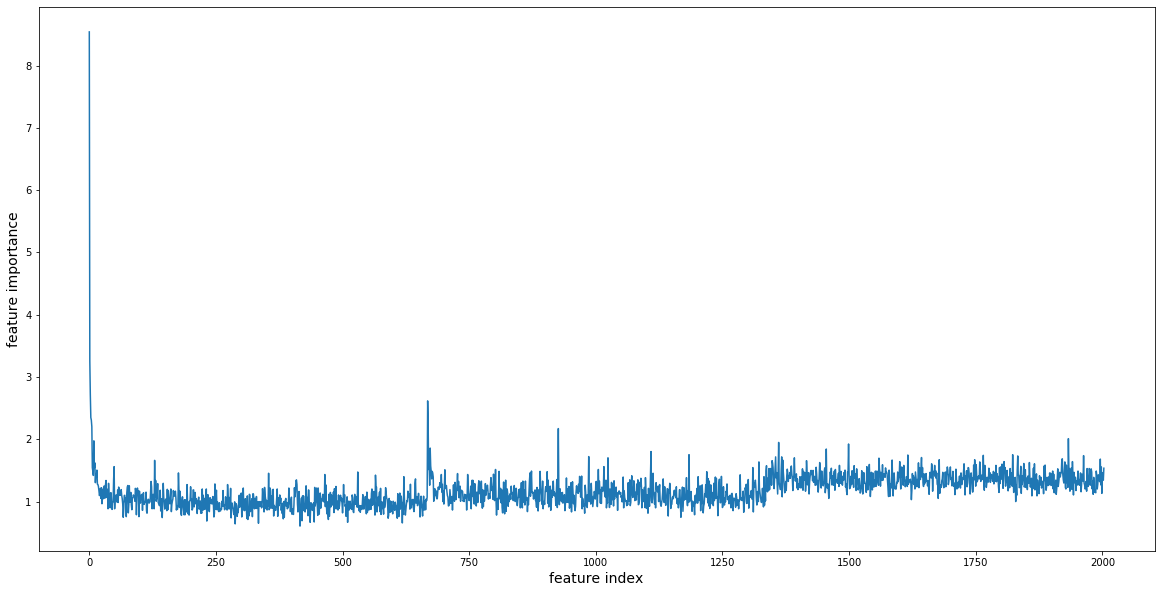

In [158]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_random_mordred_bm_fis.png', dpi=100)

In [159]:
plt.close()

### Shuffle Mordred vectors, leaving outputs the same (shuffle Mordred)
Trains model on fake reactions, testing on same test set of real ones

In [91]:
# Show Mordred dataset for comparison
X_train_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,4,5.151435e-14,3.248435,0,0,0.000000,1824.920267,0.0,3.962406e-01,-5.273559e-16,...,0,0.000000,0,0.078367,0.0,0,0,0.000000,0,0.000000
1,3,8.988986e+00,1.945910,0,0,0.000000,2778.834070,0.0,2.250000e+00,-4.483640e-01,...,1,12.622999,0,0.160000,0.0,0,0,0.000000,0,0.000000
2,5,-3.553735e+00,3.812203,0,0,9.495353,2205.387025,0.0,-1.332268e-15,7.105766e-01,...,0,0.000000,0,1.054694,0.0,0,0,5.687386,0,0.000000
3,4,-1.080025e-12,3.409496,0,0,0.000000,1749.231451,0.0,0.000000e+00,-6.245005e-16,...,0,0.692589,0,1.725714,0.0,0,0,5.687386,0,0.000000
4,10,4.170063e+01,4.290459,0,0,4.895483,4425.946139,0.0,6.037853e-01,5.718414e-01,...,2,0.000000,0,0.933878,0.0,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,8,1.024338e+02,4.861749,0,0,0.000000,4930.648221,0.0,2.110902e-01,5.068421e-01,...,2,2.240650,0,0.852290,0.0,0,0,0.000000,0,17.075242
36497,10,2.457235e+01,4.963718,1,0,0.000000,5375.068238,0.0,3.888469e-01,-2.241072e-01,...,0,4.568010,0,0.798413,0.0,0,0,0.000000,0,22.762629
36498,10,2.498193e+01,4.945207,0,0,17.473213,6024.814665,0.0,1.299257e+00,-2.227146e-01,...,0,11.395192,0,0.796871,0.0,0,0,0.000000,0,39.850954
36499,4,2.557954e-13,3.457893,0,0,0.000000,1777.825008,0.0,1.666667e-01,-9.887924e-17,...,0,0.000000,0,0.544490,0.0,0,0,0.000000,0,22.998047


In [92]:
# Shuffle row ordering removing index
X_train_mordred_shuffle = np.random.permutation(X_train_mordred.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_mordred_shuffle_inputs = pd.DataFrame(
    X_train_mordred_shuffle, index=X_train_mordred.index, 
    columns=X_train_mordred.columns
)

# View new dataframe (can see inputs have changed)
X_train_mordred_shuffle_inputs

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,8.0,1.869174e+01,4.114964,0.0,0.0,0.000000,4079.195840,0.0,3.200000e-01,6.835794e-01,...,0.0,0.000000,0.0,0.320862,0.204124,0.0,0.0,11.594566,0.0,0.000000
1,4.0,5.151435e-14,3.248435,0.0,0.0,0.000000,1824.920267,0.0,3.962406e-01,-5.273559e-16,...,0.0,2.356759,0.0,0.545488,0.000000,0.0,0.0,0.000000,0.0,5.687386
2,4.0,5.151435e-14,3.248435,0.0,0.0,0.000000,1824.920267,0.0,3.962406e-01,-5.273559e-16,...,0.0,4.811389,0.0,0.954603,0.000000,0.0,0.0,0.000000,0.0,11.374773
3,5.0,1.894290e+01,3.669951,0.0,0.0,5.022633,2250.738807,0.0,-1.332268e-15,5.165154e-01,...,0.0,0.000000,0.0,0.241633,0.000000,0.0,0.0,5.687386,0.0,0.000000
4,8.0,3.099652e+02,3.974998,0.0,0.0,0.000000,3883.123957,0.0,5.231716e-01,-1.697582e+00,...,0.0,0.000000,0.0,0.241633,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,4.0,1.874406e+01,4.066888,1.0,0.0,0.000000,2520.018476,0.0,1.250000e-01,2.560429e-01,...,0.0,2.240741,0.0,0.101224,0.000000,0.0,0.0,0.000000,0.0,5.687386
36497,12.0,5.951933e+01,4.269697,0.0,0.0,0.000000,5131.028400,0.0,1.234680e+00,-6.937658e-01,...,2.0,6.804384,0.0,1.151837,0.000000,0.0,0.0,0.000000,0.0,11.499024
36498,3.0,2.753689e+01,1.945910,0.0,0.0,0.000000,2568.127641,0.0,1.333333e+00,-8.293361e-01,...,1.0,0.000000,0.0,0.101224,0.000000,0.0,0.0,0.000000,0.0,0.000000
36499,2.0,5.705709e+00,1.791759,0.0,0.0,0.000000,2382.676355,0.0,1.285714e+00,-2.097937e-01,...,1.0,0.000000,0.0,0.024444,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [93]:
# But indices have stayed the same
X_train_mordred_shuffle_inputs.index

Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               10,
            ...
            36486, 36488, 36490, 36491, 36492, 36493, 36497, 36498, 36499,
            36500],
           dtype='int64', length=32386)

In [94]:
X_train_mordred.index

Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               10,
            ...
            36486, 36488, 36490, 36491, 36492, 36493, 36497, 36498, 36499,
            36500],
           dtype='int64', length=32386)

In [95]:
# Check test set
X_test_mordred

,rdfred_1_Diameter,rdfred_1_ATSC1m,rdfred_1_piPC3,rdfred_1_n5aHRing,rdfred_1_n4AHRing,rdfred_1_EState_VSA3,rdfred_1_ATS0i,rdfred_1_SaaSe,rdfred_1_CIC3,rdfred_1_ATSC1p,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
5,8,4.397814e+00,3.876396,0,0,10.036171,3315.876515,0.0,4.528464e-01,-3.879077e-01,...,0,0.000000,0,0.812245,0.0,0,0,0.0,0,11.257379
32,4,1.989757e+01,4.066888,1,0,0.000000,2419.546530,0.0,8.881784e-16,-1.652673e-02,...,0,1.523333,0,0.503719,0.0,0,0,0.0,0,5.687386
70,4,9.947598e-14,3.248435,0,0,0.000000,1794.583232,0.0,3.962406e-01,9.020562e-16,...,0,0.000000,0,0.041633,0.0,0,0,0.0,0,0.000000
72,4,9.947598e-14,3.248435,0,0,0.000000,1794.583232,0.0,3.962406e-01,9.020562e-16,...,0,0.000000,0,0.041633,0.0,0,0,0.0,0,0.000000
78,4,9.947598e-14,3.248435,0,0,0.000000,1794.583232,0.0,3.962406e-01,9.020562e-16,...,0,0.000000,0,0.204082,0.0,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36473,7,8.090968e+01,4.310799,0,0,0.000000,3504.361011,0.0,3.478261e-01,8.693692e-01,...,1,0.000000,0,0.556735,0.0,0,0,0.0,0,0.000000
36476,7,8.090968e+01,4.310799,0,0,0.000000,3504.361011,0.0,3.478261e-01,8.693692e-01,...,1,0.000000,0,0.760816,0.0,0,0,0.0,0,34.163568
36487,7,8.090968e+01,4.310799,0,0,0.000000,3504.361011,0.0,3.478261e-01,8.693692e-01,...,1,0.000000,0,0.618776,0.0,0,0,0.0,0,0.000000
36494,4,5.151435e-14,3.248435,0,0,0.000000,1824.920267,0.0,3.962406e-01,-5.273559e-16,...,0,2.362683,0,0.658821,0.0,0,0,0.0,0,5.687386


In [96]:
# Re-train and test model
start_time = time.time()
shuffle_mordred_file = 'shuffle_mordred_bm_gbm.model.joblib'
shuffle_mordred_bm_gbm = train_lgbm_classifier(
    X_train_mordred_shuffle_inputs, y_train, shuffle_mordred_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_mordred_bm_preds = shuffle_mordred_bm_gbm.predict_proba(X_test_mordred)

# Get top-k predicted rankings from prediction set
shuffle_mordred_bm_preds_labeled = get_top_k_preds(
    shuffle_mordred_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_mordred_bm_formatted_results = format_results_for_metrics(
    shuffle_mordred_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_mordred_bm_metrics = get_metrics_dict(
    shuffle_mordred_bm_formatted_results, type_count, 
    'shuffle_mordred_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_mordred_top_1_acc = shuffle_mordred_bm_metrics['top_1_acc']
shuffle_mordred_top_3_acc = shuffle_mordred_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 3229.9469151496887 s
Top 1 accuracy for type  M  : 0.22813370473537606
Top 3 accuracy for type  M  : 0.6247910863509749
Top 1 accuracy for type  L  : 0.5066852367688023
Top 3 accuracy for type  L  : 0.6495821727019498
Top 1 accuracy for type  B  : 0.2161559888579387
Top 3 accuracy for type  B  : 0.6022284122562674
Top 1 accuracy for type  S  : 0.2880222841225627
Top 3 accuracy for type  S  : 0.5331476323119777
Top 1 accuracy for type  A  : 0.7980501392757661
Top 3 accuracy for type  A  : 0.9022284122562674


### Feature importances

In [160]:
num_estimators = len(shuffle_mordred_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            shuffle_mordred_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_mordred_shuffle_inputs.columns[top_fis]

print(top_fi_names)

Index(['product_JGI6', 'product_JGI7', 'product_JGI4', 'product_JGI8',
       'product_ATSC5i', 'product_JGI3', 'product_ATSC8i', 'product_ATSC8d',
       'product_JGI5', 'product_CIC3', 'product_ATSC7p', 'product_ATSC7i',
       'product_JGI9', 'product_EState_VSA7', 'product_JGI2',
       'product_ATSC4dv', 'product_ATSC7v', 'product_ATSC6d',
       'product_PEOE_VSA8', 'product_ATSC2dv'],
      dtype='object')


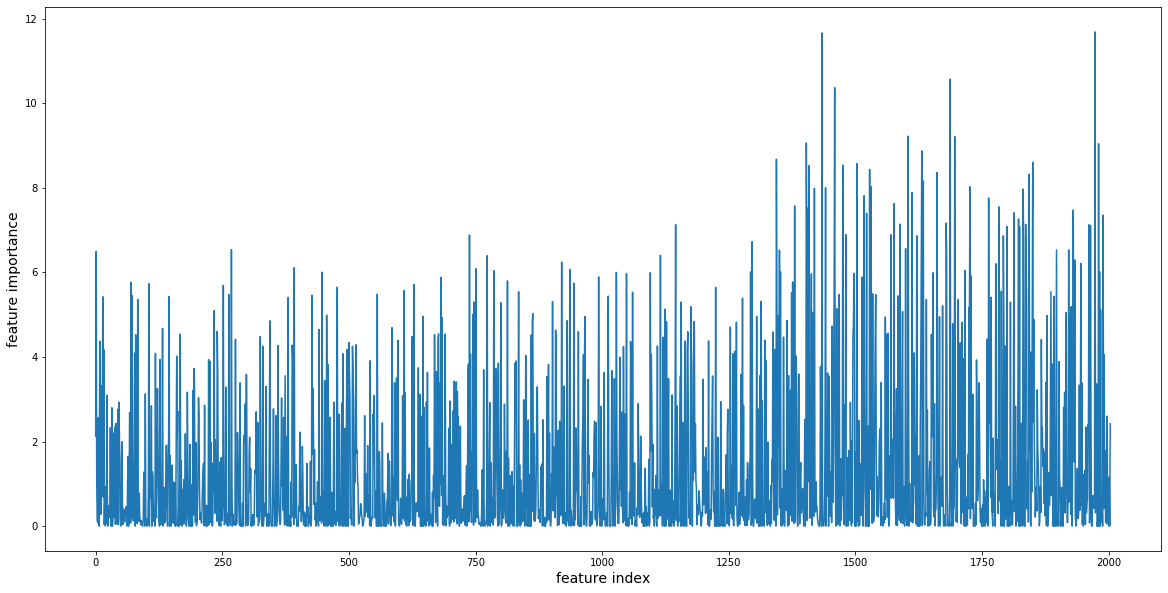

In [161]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_shuffle_mordred_bm_fis.png', dpi=100)

In [162]:
plt.close()

### Ablate Mordred region (SMILES only)

In [100]:
# Create new dataframe from only the Mordred input region
X_train_smiles = X_train[X_train.columns[:300]].copy()
X_test_smiles = X_test[X_test.columns[:300]].copy()
print(X_test_smiles.shape)

# View new dataframe (can see inputs have changed)
X_train_smiles

(3590, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,91.0,50.0,72.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36497,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36498,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36499,78.0,49.0,67.0,50.0,61.0,67.0,40.0,83.0,67.0,51.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
# Re-train and test model
start_time = time.time()
smiles_only_file = 'smiles_only_bm_gbm.model.joblib'
smiles_only_bm_gbm = train_lgbm_classifier(X_train_smiles, y_train, smiles_only_file)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
smiles_only_preds = smiles_only_bm_gbm.predict_proba(X_test_smiles)

# Get top-k predicted rankings from prediction set
smiles_only_preds_labeled = get_top_k_preds(
    smiles_only_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
smiles_only_formatted_results = format_results_for_metrics(
    smiles_only_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
smiles_only_metrics = get_metrics_dict(
    smiles_only_formatted_results, type_count, 'smiles_only_metrics.json'
)

# View top-1 and top-3 accuracy metrics
smiles_only_top_1_acc = smiles_only_metrics['top_1_acc']
smiles_only_top_3_acc = smiles_only_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 228.69827795028687 s
Top 1 accuracy for type  M  : 0.5217270194986072
Top 3 accuracy for type  M  : 0.8203342618384402
Top 1 accuracy for type  L  : 0.6350974930362117
Top 3 accuracy for type  L  : 0.8406685236768803
Top 1 accuracy for type  B  : 0.5298050139275766
Top 3 accuracy for type  B  : 0.8108635097493037
Top 1 accuracy for type  S  : 0.49832869080779946
Top 3 accuracy for type  S  : 0.7740947075208914
Top 1 accuracy for type  A  : 0.8061281337047354
Top 3 accuracy for type  A  : 0.9370473537604457


### Feature importances

In [163]:
num_estimators = len(smiles_only_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(smiles_only_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_smiles.columns[top_fis]

print(top_fi_names)

Index(['201', '110', '0', '10', '101', '222', '111', '7', '109', '1', '219',
       '218', '113', '11', '100', '221', '220', '112', '223', '217'],
      dtype='object')


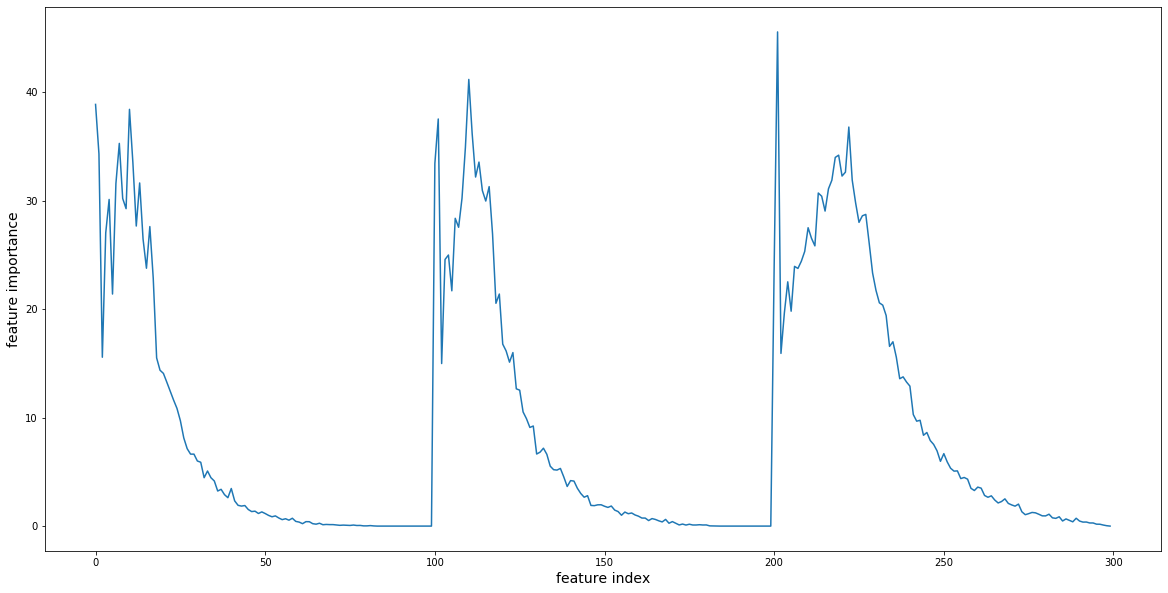

In [164]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_smiles_only_bm_fis.png', dpi=100)

In [165]:
plt.close()

### Randomized SMILES representations (random SMILES)
A random "barcode" is written for each unique molecule's SMILES drawing from a standard normal distribution. Essentially removes any continuity between chemical space, only identifying the unique molecules in a reaction.

In [105]:
# Get all unique tokenized SMILES from dataset
# Separate molecules
reactant_1_smiles = pd.DataFrame(
    X_full[X_full.columns[:100]].copy().values, index=X_full.index.values
)
reactant_2_smiles = pd.DataFrame(
    X_full[X_full.columns[100:200]].copy().values, index=X_full.index.values
)
product_smiles = pd.DataFrame(
    X_full[X_full.columns[200:300]].copy().values, index=X_full.index.values
)

# Join tabulated SMILES to single lists
for df in [reactant_1_smiles, reactant_2_smiles, product_smiles]:
    df['joined'] = df.values.tolist()
    df['str_joined'] = df['joined'].astype('str')

# Create dataframe with all unique SMILES from the dataset
unique_smiles = pd.concat(
    [reactant_1_smiles, reactant_2_smiles, product_smiles], ignore_index=True
)
print(f'Total SMILES: {len(unique_smiles)}')
unique_smiles = unique_smiles.drop_duplicates(subset=['str_joined'])
print(f'Unique SMILES: {len(unique_smiles)}')

# Create random fake SMILES representations for all unique molecules
unique_smiles['random'] = [
    np.random.randint(115, size=100).tolist() 
    for _ in range(len(unique_smiles))
]
unique_smiles['str_random'] = unique_smiles['random'].astype('str')
unique_smiles

Total SMILES: 107928
Unique SMILES: 32468


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,random,str_random
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[10, 62, 112, 36, 76, 58, 45, 84, 2, 93, 48, 6...","[10, 62, 112, 36, 76, 58, 45, 84, 2, 93, 48, 6..."
1,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 49.0, 67.0, 78.0, 67.0, 67.0, 78.0, 49....","[67.0, 49.0, 67.0, 78.0, 67.0, 67.0, 78.0, 49....","[6, 101, 47, 68, 74, 2, 79, 53, 1, 58, 65, 73,...","[6, 101, 47, 68, 74, 2, 79, 53, 1, 58, 65, 73,..."
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[110, 9, 68, 85, 5, 39, 77, 34, 34, 8, 66, 33,...","[110, 9, 68, 85, 5, 39, 77, 34, 34, 8, 66, 33,..."
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[59, 49, 45, 105, 54, 74, 39, 55, 55, 109, 40,...","[59, 49, 45, 105, 54, 74, 39, 55, 55, 109, 40,..."
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[38, 77, 57, 36, 91, 112, 81, 68, 32, 37, 70, ...","[38, 77, 57, 36, 91, 112, 81, 68, 32, 37, 70, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107923,83.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[34, 56, 49, 23, 46, 11, 11, 98, 61, 25, 26, 1...","[34, 56, 49, 23, 46, 11, 11, 98, 61, 25, 26, 1..."
107924,83.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[33, 28, 113, 10, 83, 76, 55, 53, 71, 4, 42, 3...","[33, 28, 113, 10, 83, 76, 55, 53, 71, 4, 42, 3..."
107925,83.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[32, 97, 46, 59, 18, 53, 66, 27, 7, 46, 75, 1,...","[32, 97, 46, 59, 18, 53, 66, 27, 7, 46, 75, 1,..."
107926,83.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[87, 49, 93, 33, 114, 22, 79, 96, 0, 55, 101, ...","[87, 49, 93, 33, 114, 22, 79, 96, 0, 55, 101, ..."


In [106]:
# Create mapping from true SMILES to ranom SMILES
smiles_random_dict = dict(zip(unique_smiles['str_joined'], unique_smiles['str_random']))
len(smiles_random_dict)

32468

In [107]:
# Apply mapping to all SMILES from the dataset
for df in [reactant_1_smiles, reactant_2_smiles, product_smiles]:
    df['str_random'] = df['str_joined'].map(smiles_random_dict)
    df['random'] = [json.loads(_) for _ in df['str_random']]
reactant_1_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[10, 62, 112, 36, 76, 58, 45, 84, 2, 93, 48, 6...","[10, 62, 112, 36, 76, 58, 45, 84, 2, 93, 48, 6..."
1,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 49.0, 67.0, 78.0, 67.0, 67.0, 78.0, 49....","[67.0, 49.0, 67.0, 78.0, 67.0, 67.0, 78.0, 49....","[6, 101, 47, 68, 74, 2, 79, 53, 1, 58, 65, 73,...","[6, 101, 47, 68, 74, 2, 79, 53, 1, 58, 65, 73,..."
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[110, 9, 68, 85, 5, 39, 77, 34, 34, 8, 66, 33,...","[110, 9, 68, 85, 5, 39, 77, 34, 34, 8, 66, 33,..."
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[59, 49, 45, 105, 54, 74, 39, 55, 55, 109, 40,...","[59, 49, 45, 105, 54, 74, 39, 55, 55, 109, 40,..."
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[38, 77, 57, 36, 91, 112, 81, 68, 32, 37, 70, ...","[38, 77, 57, 36, 91, 112, 81, 68, 32, 37, 70, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[78.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[11, 100, 2, 96, 32, 58, 85, 97, 10, 63, 61, 7...","[11, 100, 2, 96, 32, 58, 85, 97, 10, 63, 61, 7..."
36497,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[78.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[110, 90, 61, 114, 51, 21, 2, 86, 47, 51, 21, ...","[110, 90, 61, 114, 51, 21, 2, 86, 47, 51, 21, ..."
36498,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[78.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[110, 90, 61, 114, 51, 21, 2, 86, 47, 51, 21, ...","[110, 90, 61, 114, 51, 21, 2, 86, 47, 51, 21, ..."
36499,78.0,49.0,67.0,50.0,61.0,67.0,40.0,83.0,67.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[78.0, 49.0, 67.0, 50.0, 61.0, 67.0, 40.0, 83....","[78.0, 49.0, 67.0, 50.0, 61.0, 67.0, 40.0, 83....","[50, 82, 95, 13, 37, 80, 36, 54, 51, 88, 83, 4...","[50, 82, 95, 13, 37, 80, 36, 54, 51, 88, 83, 4..."


In [108]:
reactant_2_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,91.0,49.0,53.0,78.0,72.0,50.0,93.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 49.0, 53.0, 78.0, 72.0, 50.0, 93.0, 67....","[91.0, 49.0, 53.0, 78.0, 72.0, 50.0, 93.0, 67....","[104, 46, 62, 56, 3, 109, 29, 99, 45, 40, 16, ...","[104, 46, 62, 56, 3, 109, 29, 99, 45, 40, 16, ..."
1,91.0,49.0,56.0,70.0,93.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 49.0, 56.0, 70.0, 93.0, 67.0, 49.0, 61....","[91.0, 49.0, 56.0, 70.0, 93.0, 67.0, 49.0, 61....","[80, 25, 37, 27, 17, 38, 89, 12, 57, 66, 59, 5...","[80, 25, 37, 27, 17, 38, 89, 12, 57, 66, 59, 5..."
2,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[65, 96, 12, 106, 64, 88, 93, 6, 54, 32, 65, 3...","[65, 96, 12, 106, 64, 88, 93, 6, 54, 32, 65, 3..."
3,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[74, 100, 80, 90, 85, 114, 23, 63, 12, 81, 16,...","[74, 100, 80, 90, 85, 114, 23, 63, 12, 81, 16,..."
4,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,79.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 67.0, 40.0, 67.0, 41.0, 40.0, 67.0, 41....","[67.0, 67.0, 40.0, 67.0, 41.0, 40.0, 67.0, 41....","[114, 30, 73, 20, 95, 78, 64, 15, 88, 81, 64, ...","[114, 30, 73, 20, 95, 78, 64, 15, 88, 81, 64, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[66.0, 114.0, 67.0, 49.0, 61.0, 67.0, 67.0, 61...","[86, 97, 113, 3, 83, 62, 11, 16, 7, 98, 26, 69...","[86, 97, 113, 3, 83, 62, 11, 16, 7, 98, 26, 69..."
36497,67.0,108.0,67.0,49.0,61.0,67.0,67.0,40.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40...","[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40...","[21, 69, 108, 11, 96, 91, 63, 1, 44, 114, 92, ...","[21, 69, 108, 11, 96, 91, 63, 1, 44, 114, 92, ..."
36498,67.0,108.0,67.0,49.0,61.0,67.0,67.0,40.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40...","[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40...","[4, 87, 30, 0, 27, 111, 3, 99, 104, 31, 92, 99...","[4, 87, 30, 0, 27, 111, 3, 99, 104, 31, 92, 99..."
36499,67.0,108.0,67.0,49.0,61.0,67.0,67.0,40.0,61.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40...","[67.0, 108.0, 67.0, 49.0, 61.0, 67.0, 67.0, 40...","[61, 94, 94, 73, 50, 101, 41, 22, 85, 16, 48, ...","[61, 94, 94, 73, 50, 101, 41, 22, 85, 16, 48, ..."


In [109]:
product_smiles

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,joined,str_joined,str_random,random
0,91.0,49.0,53.0,78.0,72.0,93.0,40.0,67.0,49.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 49.0, 53.0, 78.0, 72.0, 93.0, 40.0, 67....","[91.0, 49.0, 53.0, 78.0, 72.0, 93.0, 40.0, 67....","[107, 97, 86, 3, 22, 50, 40, 35, 40, 39, 103, ...","[107, 97, 86, 3, 22, 50, 40, 35, 40, 39, 103, ..."
1,91.0,49.0,56.0,70.0,93.0,67.0,49.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 49.0, 56.0, 70.0, 93.0, 67.0, 49.0, 61....","[91.0, 49.0, 56.0, 70.0, 93.0, 67.0, 49.0, 61....","[30, 17, 99, 65, 70, 6, 74, 83, 46, 104, 47, 2...","[30, 17, 99, 65, 70, 6, 74, 83, 46, 104, 47, 2..."
2,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[108, 22, 60, 14, 0, 1, 87, 48, 106, 58, 113, ...","[108, 22, 60, 14, 0, 1, 87, 48, 106, 58, 113, ..."
3,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[66, 92, 6, 46, 113, 48, 102, 75, 3, 97, 95, 2...","[66, 92, 6, 46, 113, 48, 102, 75, 3, 97, 95, 2..."
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[91.0, 50.0, 72.0, 93.0, 67.0, 40.0, 91.0, 50....","[54, 59, 108, 79, 113, 5, 80, 114, 20, 82, 72,...","[54, 59, 108, 79, 113, 5, 80, 114, 20, 82, 72,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,83.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[34, 56, 49, 23, 46, 11, 11, 98, 61, 25, 26, 1...","[34, 56, 49, 23, 46, 11, 11, 98, 61, 25, 26, 1..."
36497,83.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[33, 28, 113, 10, 83, 76, 55, 53, 71, 4, 42, 3...","[33, 28, 113, 10, 83, 76, 55, 53, 71, 4, 42, 3..."
36498,83.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[32, 97, 46, 59, 18, 53, 66, 27, 7, 46, 75, 1,...","[32, 97, 46, 59, 18, 53, 66, 27, 7, 46, 75, 1,..."
36499,83.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,"[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[83.0, 49.0, 67.0, 50.0, 61.0, 67.0, 67.0, 61....","[87, 49, 93, 33, 114, 22, 79, 96, 0, 55, 101, ...","[87, 49, 93, 33, 114, 22, 79, 96, 0, 55, 101, ..."


In [110]:
reactant_1_smiles = pd.DataFrame(
    list(reactant_1_smiles['random'].values), columns=list(np.arange(0, 100)),
    index=X_full.index.values
)
reactant_2_smiles = pd.DataFrame(
    list(reactant_2_smiles['random'].values), columns=list(np.arange(100, 200)),
    index=X_full.index.values
)
product_smiles = pd.DataFrame(
    list(product_smiles['random'].values), columns=list(np.arange(200, 300)),
    index=X_full.index.values
)
reactant_1_smiles

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,10,62,112,36,76,58,45,84,2,93,...,76,44,103,83,109,114,71,60,11,43
1,6,101,47,68,74,2,79,53,1,58,...,74,15,60,36,27,31,38,26,59,13
2,110,9,68,85,5,39,77,34,34,8,...,1,56,17,96,85,101,27,13,39,81
3,59,49,45,105,54,74,39,55,55,109,...,97,88,82,49,42,55,0,10,37,16
4,38,77,57,36,91,112,81,68,32,37,...,110,46,87,105,97,20,64,105,105,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,11,100,2,96,32,58,85,97,10,63,...,94,30,113,113,63,35,77,95,54,108
36497,110,90,61,114,51,21,2,86,47,51,...,33,99,18,78,20,10,45,33,112,45
36498,110,90,61,114,51,21,2,86,47,51,...,33,99,18,78,20,10,45,33,112,45
36499,50,82,95,13,37,80,36,54,51,88,...,47,54,35,83,62,24,90,50,94,8


In [111]:
reactant_2_smiles

,100,101,102,103,104,105,106,107,108,109,...,190,191,192,193,194,195,196,197,198,199
0,104,46,62,56,3,109,29,99,45,40,...,92,32,84,89,6,0,97,80,58,98
1,80,25,37,27,17,38,89,12,57,66,...,16,56,97,60,88,22,78,5,110,29
2,65,96,12,106,64,88,93,6,54,32,...,79,9,85,80,53,21,101,43,21,13
3,74,100,80,90,85,114,23,63,12,81,...,52,84,65,66,91,65,36,15,105,43
4,114,30,73,20,95,78,64,15,88,81,...,87,19,18,76,110,97,28,31,19,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,86,97,113,3,83,62,11,16,7,98,...,5,61,17,73,37,98,103,51,27,96
36497,21,69,108,11,96,91,63,1,44,114,...,111,79,113,46,37,59,58,33,57,81
36498,4,87,30,0,27,111,3,99,104,31,...,33,31,36,54,6,23,29,59,87,59
36499,61,94,94,73,50,101,41,22,85,16,...,27,56,44,102,113,51,94,79,107,32


In [113]:
product_smiles

,200,201,202,203,204,205,206,207,208,209,...,290,291,292,293,294,295,296,297,298,299
0,107,97,86,3,22,50,40,35,40,39,...,17,56,24,90,110,65,76,79,72,11
1,30,17,99,65,70,6,74,83,46,104,...,104,42,4,72,52,68,7,21,96,12
2,108,22,60,14,0,1,87,48,106,58,...,25,72,10,22,27,84,0,29,84,114
3,66,92,6,46,113,48,102,75,3,97,...,110,67,53,49,37,50,75,51,21,64
4,54,59,108,79,113,5,80,114,20,82,...,6,48,72,4,28,89,7,37,8,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,34,56,49,23,46,11,11,98,61,25,...,18,70,70,107,53,95,41,47,18,35
36497,33,28,113,10,83,76,55,53,71,4,...,97,56,62,33,42,86,3,86,79,71
36498,32,97,46,59,18,53,66,27,7,46,...,110,38,97,106,113,1,41,57,56,74
36499,87,49,93,33,114,22,79,96,0,55,...,56,25,58,100,71,102,44,23,30,27


In [114]:
# Re-combine component molecules into full dataframe
X_full_random_smiles = pd.concat(
    [reactant_1_smiles, reactant_2_smiles, product_smiles], axis=1
)

# View new dataframe
X_full_random_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,10,62,112,36,76,58,45,84,2,93,...,17,56,24,90,110,65,76,79,72,11
1,6,101,47,68,74,2,79,53,1,58,...,104,42,4,72,52,68,7,21,96,12
2,110,9,68,85,5,39,77,34,34,8,...,25,72,10,22,27,84,0,29,84,114
3,59,49,45,105,54,74,39,55,55,109,...,110,67,53,49,37,50,75,51,21,64
4,38,77,57,36,91,112,81,68,32,37,...,6,48,72,4,28,89,7,37,8,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36495,11,100,2,96,32,58,85,97,10,63,...,18,70,70,107,53,95,41,47,18,35
36497,110,90,61,114,51,21,2,86,47,51,...,97,56,62,33,42,86,3,86,79,71
36498,110,90,61,114,51,21,2,86,47,51,...,110,38,97,106,113,1,41,57,56,74
36499,50,82,95,13,37,80,36,54,51,88,...,56,25,58,100,71,102,44,23,30,27


In [115]:
# Re-split full dataset based on test indices
X_train_random_smiles = X_full_random_smiles[
    ~X_full_random_smiles.index.isin(test_inds)
]
X_test_random_smiles = X_full_random_smiles[
    X_full_random_smiles.index.isin(test_inds)
]

# Check sets
print(X_train_random_smiles.shape, y_train.shape, 
      X_test_random_smiles.shape, y_test.shape)

(32386, 300) (32386, 205) (3590, 300) (3590, 205)


In [116]:
# Re-train and test model
start_time = time.time()
random_smiles_file = 'random_smiles_bm_gbm.model.joblib'
random_smiles_bm_gbm = train_lgbm_classifier(
    X_train_random_smiles, y_train, random_smiles_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_smiles_preds = random_smiles_bm_gbm.predict_proba(X_test_random_smiles)

# Get top-k predicted rankings from prediction set
random_smiles_preds_labeled = get_top_k_preds(
    random_smiles_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(y_test, cutoffs, category_initials,
                                    include_nulls=True)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_smiles_formatted_results = format_results_for_metrics(
    random_smiles_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_smiles_metrics = get_metrics_dict(
    random_smiles_formatted_results, type_count, 'random_smiles_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_smiles_top_1_acc = random_smiles_metrics['top_1_acc']
random_smiles_top_3_acc = random_smiles_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 524.9903690814972 s
Top 1 accuracy for type  M  : 0.4927576601671309
Top 3 accuracy for type  M  : 0.7791086350974931
Top 1 accuracy for type  L  : 0.5824512534818942
Top 3 accuracy for type  L  : 0.8041782729805014
Top 1 accuracy for type  B  : 0.5211699164345404
Top 3 accuracy for type  B  : 0.7955431754874652
Top 1 accuracy for type  S  : 0.5005571030640669
Top 3 accuracy for type  S  : 0.7532033426183844
Top 1 accuracy for type  A  : 0.7052924791086351
Top 3 accuracy for type  A  : 0.9270194986072423


### Feature importances

In [166]:
num_estimators = len(random_smiles_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(
            random_smiles_bm_gbm.estimators_[i].feature_importances_
        ) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)

top_fis = np.argsort(-average_fis)[:20]

top_fi_names = X_train_random_smiles.columns[top_fis]

print(top_fi_names)

Int64Index([  0, 140,   2, 135,   1, 189, 145, 128, 138, 120, 170, 139, 126,
            152, 162, 124, 137,  15, 155, 116],
           dtype='int64')


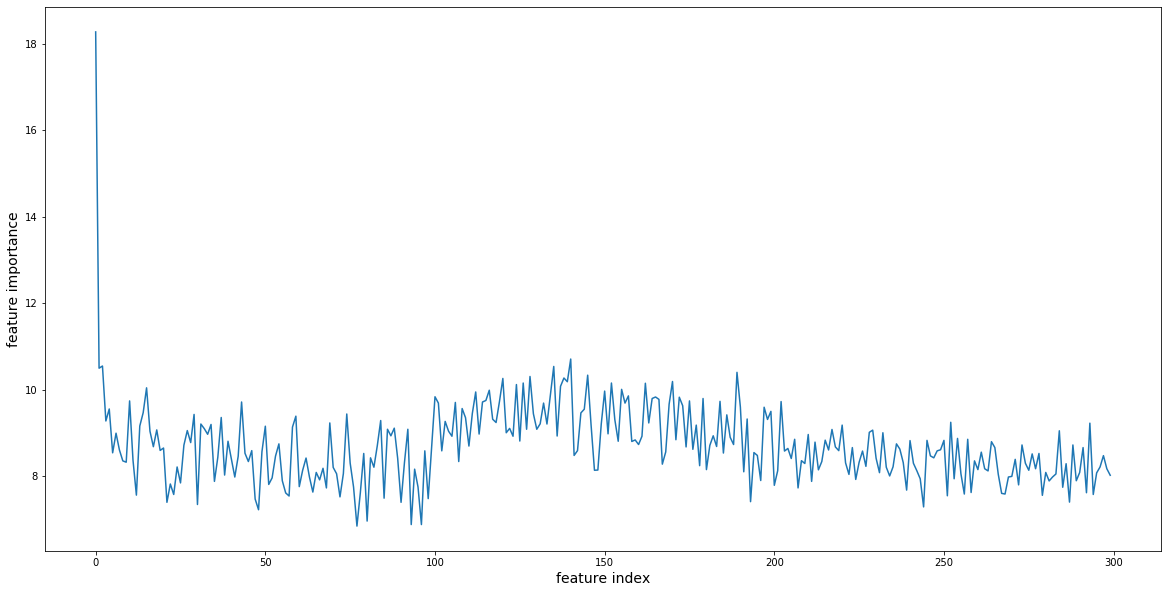

In [167]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_random_smiles_bm_fis.png', dpi=100)

In [168]:
plt.close()

### Shuffle SMILES vectors, leaving outputs the same (shuffle SMILES)
Trains model on fake reactions, testing on same test set of real ones

In [120]:
# Show SMILES dataset for comparison
X_train_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,91.0,50.0,72.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36497,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36498,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36499,78.0,49.0,67.0,50.0,61.0,67.0,40.0,83.0,67.0,51.0,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
# Shuffle row ordering removing index
X_train_smiles_shuffle = np.random.permutation(X_train_smiles.copy().values)

# Create new dataframe with the shuffled rows, retaining original indices
X_train_smiles_shuffle_inputs = pd.DataFrame(
    X_train_smiles_shuffle, index=X_train_smiles.index, 
    columns=X_train_smiles.columns
)

# View new dataframe (can see inputs have changed)
X_train_smiles_shuffle_inputs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,67.0,83.0,40.0,61.0,79.0,41.0,40.0,61.0,79.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,67.0,67.0,40.0,67.0,41.0,40.0,67.0,41.0,67.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,78.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,67.0,49.0,67.0,67.0,78.0,67.0,67.0,49.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36497,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36498,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36499,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
# But indices have stayed the same
X_train_smiles_shuffle_inputs.index

Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               10,
            ...
            36486, 36488, 36490, 36491, 36492, 36493, 36497, 36498, 36499,
            36500],
           dtype='int64', length=32386)

In [123]:
X_train_smiles.index

Int64Index([    0,     1,     2,     3,     4,     6,     7,     8,     9,
               10,
            ...
            36486, 36488, 36490, 36491, 36492, 36493, 36497, 36498, 36499,
            36500],
           dtype='int64', length=32386)

In [124]:
# Check test set
X_test_smiles

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
5,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,78.0,49.0,67.0,61.0,67.0,67.0,50.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36473,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,41.0,61.0,67.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0
36476,70.0,67.0,40.0,70.0,41.0,40.0,70.0,41.0,83.0,40.0,...,49.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36487,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36494,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
# Re-train and test model
start_time = time.time()
shuffle_smiles_file = 'shuffle_smiles_bm_gbm.model.joblib'
shuffle_smiles_bm_gbm = train_lgbm_classifier(
    X_train_smiles_shuffle_inputs, y_train, shuffle_smiles_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
shuffle_smiles_bm_preds = shuffle_smiles_bm_gbm.predict_proba(X_test_smiles)

# Get top-k predicted rankings from prediction set
shuffle_smiles_bm_preds_labeled = get_top_k_preds(
    shuffle_smiles_bm_preds, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
shuffle_smiles_bm_formatted_results = format_results_for_metrics(
    shuffle_smiles_bm_preds_labeled, y_test_labeled, type_count, 
    category_initials
)

# Calculate metrics and save results file
shuffle_smiles_bm_metrics = get_metrics_dict(
    shuffle_smiles_bm_formatted_results, type_count, 
    'shuffle_smiles_bm_metrics.json'
)

# View top-1 and top-3 accuracy metrics
shuffle_smiles_top_1_acc = shuffle_smiles_bm_metrics['top_1_acc']
shuffle_smiles_top_3_acc = shuffle_smiles_bm_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 236.84849786758423 s
Top 1 accuracy for type  M  : 0.22813370473537606
Top 3 accuracy for type  M  : 0.6247910863509749
Top 1 accuracy for type  L  : 0.5094707520891365
Top 3 accuracy for type  L  : 0.637883008356546
Top 1 accuracy for type  B  : 0.22395543175487465
Top 3 accuracy for type  B  : 0.6103064066852367
Top 1 accuracy for type  S  : 0.3008356545961003
Top 3 accuracy for type  S  : 0.5370473537604457
Top 1 accuracy for type  A  : 0.8378830083565459
Top 3 accuracy for type  A  : 0.9033426183844011


## Fully random inputs (random inputs)
Combine random SMILES and random Mordred inputs

In [126]:
# Re-combine random SMILES and random Mordred dataframes
X_train_random_inputs = pd.concat(
    [X_train_random_smiles, X_train_random_mordred], axis=1
)
X_test_random_inputs = pd.concat(
    [X_test_random_smiles, X_test_random_mordred], axis=1
)

# View new dataframe
X_train_random_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,10,62,112,36,76,58,45,84,2,93,...,275367.229446,241260.616633,70005.024377,444947.651858,186492.367617,217082.094123,306902.700167,327371.848051,106761.786953,170758.413872
1,6,101,47,68,74,2,79,53,1,58,...,170377.022407,24989.271722,396391.496592,73630.786251,13532.386581,193816.521808,211955.396933,120464.768201,148677.150618,123236.045839
2,110,9,68,85,5,39,77,34,34,8,...,97869.849974,149351.020367,314845.436062,68342.067727,137067.156904,422501.063323,405122.954654,434126.334481,101324.572824,399354.456588
3,59,49,45,105,54,74,39,55,55,109,...,427766.354519,231098.446938,394897.033484,4302.205961,326740.704986,105779.383547,107901.159888,100006.641451,345648.075641,254143.049445
4,38,77,57,36,91,112,81,68,32,37,...,383779.407153,50726.189692,35247.058031,210726.294859,349520.294723,216709.676456,334419.212564,187437.226259,269067.394385,120509.995329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,11,100,2,96,32,58,85,97,10,63,...,408898.387286,417022.714944,131116.398113,124375.011923,260083.792187,18798.307891,13299.695311,4693.423787,150456.891508,298959.836278
36497,110,90,61,114,51,21,2,86,47,51,...,316612.249533,122147.403744,57974.443384,301012.149501,106460.822515,233290.553101,281341.869712,133882.349858,203851.354580,14454.306503
36498,110,90,61,114,51,21,2,86,47,51,...,140203.200567,16854.621108,173704.449414,75440.036703,414736.118538,171592.284393,202330.194084,67062.395587,197532.135682,48649.984639
36499,50,82,95,13,37,80,36,54,51,88,...,390021.853987,7683.176518,57996.389086,271167.720622,101943.078421,354259.950681,9811.740262,195056.119356,26761.284117,46952.837589


In [127]:
# Compare to original dataset
X_train

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
0,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.000000,0,0.078367,0.0,0,0,0.000000,0,0.000000
1,67.0,49.0,67.0,78.0,67.0,67.0,78.0,49.0,0.0,0.0,...,1,12.622999,0,0.160000,0.0,0,0,0.000000,0,0.000000
2,67.0,108.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,0,0.000000,0,1.054694,0.0,0,0,5.687386,0,0.000000
3,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,0.692589,0,1.725714,0.0,0,0,5.687386,0,0.000000
4,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,2,0.000000,0,0.933878,0.0,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36493,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,2,2.240650,0,0.852290,0.0,0,0,0.000000,0,17.075242
36497,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,4.568010,0,0.798413,0.0,0,0,0.000000,0,22.762629
36498,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,11.395192,0,0.796871,0.0,0,0,0.000000,0,39.850954
36499,78.0,49.0,67.0,50.0,61.0,67.0,40.0,83.0,67.0,51.0,...,0,0.000000,0,0.544490,0.0,0,0,0.000000,0,22.998047


In [128]:
X_test_random_inputs

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
5,100,101,75,36,15,101,107,1,45,72,...,260337.165275,300030.511244,38427.872527,339595.565339,255280.161304,35797.585098,353657.582349,445507.780985,188642.681770,394570.937094
32,3,69,6,66,91,85,48,36,35,54,...,56064.481446,401952.823985,250650.460788,123419.415384,439079.729762,221083.649037,423337.725753,207624.223257,403496.670460,431345.435662
70,92,62,22,19,88,79,22,21,18,106,...,332576.504259,65104.076554,439366.338982,317781.348112,355227.811216,328864.215629,239887.702571,418073.315090,370643.780880,159858.191118
72,92,62,22,19,88,79,22,21,18,106,...,332576.504259,65104.076554,439366.338982,317781.348112,355227.811216,328864.215629,239887.702571,418073.315090,370643.780880,159858.191118
78,92,62,22,19,88,79,22,21,18,106,...,318528.106086,19136.238918,11503.928902,289773.158679,311931.621110,378433.963478,350501.928753,219308.610339,284893.950729,146981.406004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36473,31,67,69,113,44,1,101,95,43,40,...,198787.102039,230897.441921,257486.693513,311324.132930,44168.888556,263516.237879,125680.831911,407074.532742,341673.826476,298447.964062
36476,102,12,32,43,25,93,104,45,88,36,...,390382.313626,57310.868769,401832.720375,266525.029676,262905.508715,202901.298076,384888.753659,15653.129778,115718.339874,361820.404134
36487,11,41,25,94,72,0,32,26,49,73,...,174541.458818,91005.989160,92416.793482,78670.106964,279757.195480,208109.572696,439726.079148,384888.430847,51251.058111,184723.741128
36494,11,100,2,96,32,58,85,97,10,63,...,414749.946441,393823.900830,393736.508272,313915.167635,289499.898401,298968.746987,100464.170404,444249.537240,398523.107838,363279.522554


In [129]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,product_NsssN,product_VSA_EState8,product_n9FARing,product_GGI6,product_Xch-4d,product_n7AHRing,product_n10ARing,product_PEOE_VSA13,product_n7HRing,product_SMR_VSA9
5,91.0,50.0,72.0,93.0,67.0,40.0,91.0,50.0,72.0,93.0,...,0,0.000000,0,0.812245,0.0,0,0,0.0,0,11.257379
32,78.0,49.0,67.0,61.0,67.0,67.0,50.0,61.0,67.0,67.0,...,0,1.523333,0,0.503719,0.0,0,0,0.0,0,5.687386
70,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0,0.000000,0,0.041633,0.0,0,0,0.0,0,0.000000
72,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0,0.000000,0,0.041633,0.0,0,0,0.0,0,0.000000
78,73.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,67.0,61.0,...,0,0.000000,0,0.204082,0.0,0,0,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36473,66.0,114.0,67.0,49.0,61.0,67.0,67.0,61.0,67.0,40.0,...,1,0.000000,0,0.556735,0.0,0,0,0.0,0,0.000000
36476,70.0,67.0,40.0,70.0,41.0,40.0,70.0,41.0,83.0,40.0,...,1,0.000000,0,0.760816,0.0,0,0,0.0,0,34.163568
36487,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,1,0.000000,0,0.618776,0.0,0,0,0.0,0,0.000000
36494,78.0,49.0,67.0,50.0,61.0,67.0,67.0,61.0,67.0,67.0,...,0,2.362683,0,0.658821,0.0,0,0,0.0,0,5.687386


In [130]:
# Re-train and test model
start_time = time.time()
random_inputs_file = 'random_inputs_bm_gbm.model.joblib'
random_inputs_bm_gbm = train_lgbm_classifier(
    X_train_random_inputs, y_train, random_inputs_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
random_inputs_preds = random_inputs_bm_gbm.predict_proba(
    X_test_random_inputs
)

# Get top-k predicted rankings from prediction set
random_inputs_preds_labeled = get_top_k_preds(
    random_inputs_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
random_inputs_formatted_results = format_results_for_metrics(
    random_inputs_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
random_inputs_metrics = get_metrics_dict(
    random_inputs_formatted_results, type_count, 'random_inputs_metrics.json'
)

# View top-1 and top-3 accuracy metrics
random_inputs_top_1_acc = random_inputs_metrics['top_1_acc']
random_inputs_top_3_acc = random_inputs_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 4826.90124797821 s
Top 1 accuracy for type  M  : 0.47576601671309193
Top 3 accuracy for type  M  : 0.7701949860724234
Top 1 accuracy for type  L  : 0.31643454038997215
Top 3 accuracy for type  L  : 0.7615598885793872
Top 1 accuracy for type  B  : 0.4877437325905292
Top 3 accuracy for type  B  : 0.7877437325905292
Top 1 accuracy for type  S  : 0.4637883008356546
Top 3 accuracy for type  S  : 0.7284122562674095
Top 1 accuracy for type  A  : 0.6977715877437326
Top 3 accuracy for type  A  : 0.9211699164345404


### Feature importances

In [169]:
num_estimators = len(random_inputs_bm_gbm.estimators_)
all_fis = []

for i in range(num_estimators):
    try:
        all_fis.append(random_inputs_bm_gbm.estimators_[i].feature_importances_) 
    except:
        continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('cn_random_inputs_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fi_names)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

Index(['0', '1', '2', '3', '92', '138', '4', '6', '115', '36', '17', '15',
       '150', '5', '128', '199', '156', '88', '170', '44'],
      dtype='object')
Index(['0', '1', '2', '3', '92', '138', '4', '6', '115', '36', '15', '17',
       '150', '5', '128', '199', '156', '88', '170', '44'],
      dtype='object')
Index(['product_ATSC8are', 'product_SaaNH', 'product_MPC3', 'product_ATS8pe',
       'rdfred_2_SlogP_VSA11', 'rdfred_2_ATSC0dv', 'rdfred_2_SaaN',
       'rdfred_1_ATS5dv', 'product_SMR_VSA6', 'rdfred_1_ATSC4Z',
       'rdfred_2_ATSC5se', 'rdfred_1_n4ARing', 'product_SRW10',
       'product_ATSC5dv', 'rdfred_2_n12HRing', 'product_ATS3Z',
       'product_nBondsS', 'product_SRW03', 'product_EState_VSA10',
       'rdfred_2_NdsCH'],
      dtype='object')


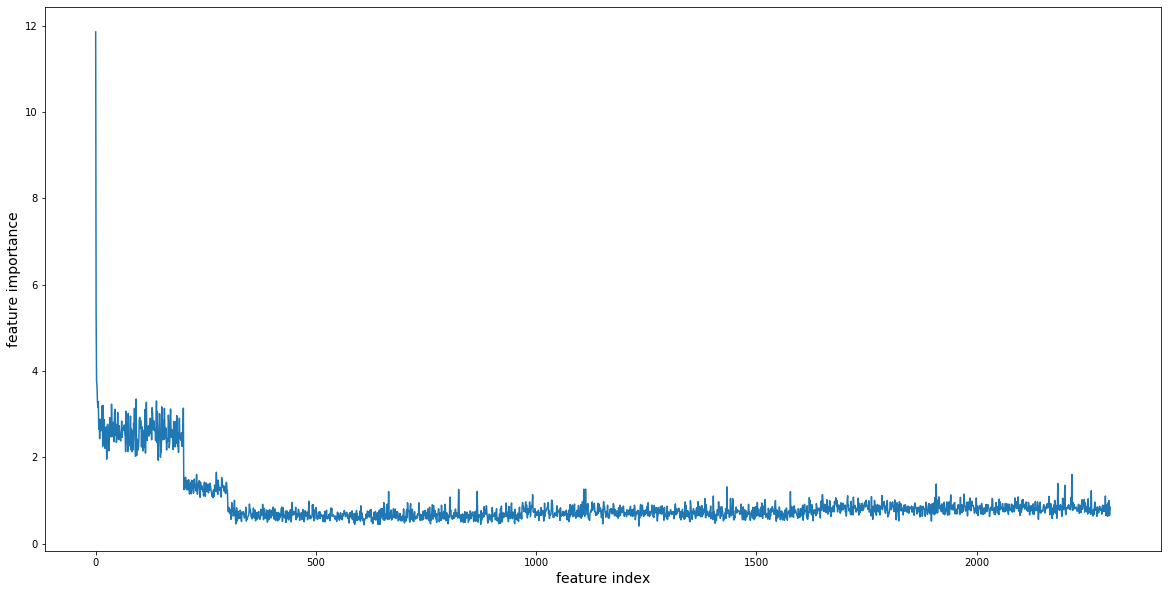

In [170]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_random_inputs_fis.png', dpi=100)

In [171]:
plt.close()

## Classifier trellis method (CT)

In [173]:
def train_one_lgbm_classifier(X_train, y_train):
    """
    Trains one LightGBM binary classifier for a single bin in the label space.
    Differs from train_lgbm_classifier as is not wrapped in a
    OneVsRestClassifier and does not add single classifiers to joblib.
    Model parameters are otherwise identical
    
    ARGUMENTs:
        (pd.DataFrame)X_train: training set inputs as pandas dataframe
        (pd.DataFrame)y_train: training set outputs as pandas dataframe
        
    RETURNS:
        (LGBMClassifier)clf: fitted lightgbm model 
    """
    clf = LGBMClassifier(
        n_jobs=-1,
        max_depth=7,
        tree_method='gpu_hist',
        gpu_id=0,
        verbosity=2,
        eval_metric='aucpr'
    )
    clf.fit(X_train, y_train)
    return clf


class ClassifierTrellis:
    def __init__(self, struct, fit_func):
        self.struct = struct
        self.fit_func = fit_func
        self.width = len(struct)
        self.clfs = [[None for col in range(self.width)]
                     for row in range(self.width)]
    
    def create_X_trellis(self, X, Y, row, col):
        """
        Forms trellis structure at given position in grid with propagation
        directions from label dependency matrix
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            (pandas.DataFrame)Y: output dataframe
            (int)row: current row index
            (int)col: current column index
            
        RETURNS:
            (pandas.DataFrame)X_trellis: trellis structure at given position
            in grid
        """
        # Set empty label propagation matrix
        n_rows = len(X)
        dep_Y = pd.DataFrame({
            'topleft': np.zeros(n_rows),
            'left': np.zeros(n_rows),
            'top': np.zeros(n_rows)
        }, index=X.index)

        # Fill in dependency matrix with output labels in each applicable
        # propagation direction
        if row > 0:
            dep_Y['top'] = Y[self.struct[row - 1][col][1]]
        if col > 0:
            dep_Y['left'] = Y[self.struct[row][col - 1][1]]
        if row > 0 and col > 0:
            dep_Y['topleft'] = Y[self.struct[row - 1][col - 1][1]]
        
        # Append label values to input vectors
        X_trellis = X.merge(dep_Y, left_index=True, right_index=True)
        return X_trellis

    def fit(self, X, Y, train_on_predictions=False):
        """
        Fits a classifier for each label in the trellis
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            (pandas.DataFrame)Y: output dataframe
            (Bool)train_on_predictions: whether to append predicted or 
            ground truth labels as the propagated inputs in training
            
        RETURNS:
            self.clfs will be fit to training data
        """
        # Set empty dataframe to fill in predicted outputs
        preds_df = pd.DataFrame(index=X.index)
        
        # Iterate through the trellis updating inputs and fitting classifiers
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                # Get current label bin to be predicted
                target_col = self.struct[row][col][1]
                if train_on_predictions:
                    # Use predictions to make trellis columns
                    X_trellis = self.create_X_trellis(X, preds_df, row, col)
                else:
                    # Use ground truth to make trellis columns
                    X_trellis = self.create_X_trellis(X, Y, row, col)
                #print("Training clf at ({}, {}) called: {}".format(row, col, target_col))
                # Train classifier for current label with updated inputs
                self.clfs[row][col] = self.fit_func(X_trellis, Y[target_col])

                # Update prediction set with outputs from current classifier
                if train_on_predictions:
                    # Create predictions for use in training
                    #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                    col_preds = self.clfs[row][col].predict_proba(X_trellis)
                    preds_df[target_col] = col_preds[:,1]

        
    def predict(self, X):
        """
        Make predictions using trellis classifiers
        
        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe
            
        RETURNS:
            (pandas.DataFrame)preds_df: predicted outputs for all examples in X
        """
        preds_df = pd.DataFrame(index=X.index)
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                target_col = self.struct[row][col][1]
                X_trellis = self.create_X_trellis(X, preds_df, row, col)
                #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                col_preds = self.clfs[row][col].predict_proba(X_trellis)
                preds_df[target_col] = col_preds[:,1]
        return preds_df
    
    def predict_on_zeros(self, X):
        """
        Make predictions using trellis classifiers removing propagated inputs

        ARGUMENTS:
            (pandas.DataFrame)X: input dataframe

        RETURNS:
            (pandas.DataFrame)preds_df: predicted outputs for all examples in X
        """
        preds_df = pd.DataFrame(index=X.index)
        for row in range(self.width):
            for col in range(self.width):
                if self.struct[row][col] is None:
                    continue
                target_col = self.struct[row][col][1]
                X_trellis = self.create_X_trellis(X, preds_df, row, col)
                #print("Predicting clf at ({}, {}) called: {}".format(row, col, target_col))
                col_preds = self.clfs[row][col].predict_proba(X_trellis)
                preds_df[target_col] = np.zeros(col_preds[:,1].shape)
        return preds_df

## Full CT model
### Trained on propagated predictions

In [174]:
# Construct classifier trellis
cn_ct = ClassifierTrellis(struct, train_one_lgbm_classifier)

# Train CT model
start_time = time.time()
cn_ct.fit(X_train, y_train, train_on_predictions=True)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Save CT model
joblib.dump(cn_ct, 'cn_ct_gbms.model.joblib')

# Make predictions with trained model
ct_full_preds = cn_ct.predict(X_test)

# Re-index to match dictionary order
ct_full_preds = ct_full_preds.reindex(y_test.columns, axis=1)

# Get top-k predicted rankings from prediction set
# Must use preds.values here as get dataframe not array from ct.predict
ct_full_preds_labeled = get_top_k_preds(
    ct_full_preds.values, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
ct_full_formatted_results = format_results_for_metrics(
    ct_full_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
ct_full_metrics = get_metrics_dict(
    ct_full_formatted_results, type_count, 'ct_metrics.json'
)

# View top-1 and top-3 accuracy metrics
ct_full_top_1_acc = ct_full_metrics['top_1_acc']
ct_full_top_3_acc = ct_full_metrics['top_k_acc']

Training complete. Training time: 4163.693036079407 s
Top 1 accuracy for type  M  : 0.4582172701949861
Top 3 accuracy for type  M  : 0.7771587743732591
Top 1 accuracy for type  L  : 0.5710306406685237
Top 3 accuracy for type  L  : 0.7927576601671309
Top 1 accuracy for type  B  : 0.5002785515320334
Top 3 accuracy for type  B  : 0.7916434540389972
Top 1 accuracy for type  S  : 0.4523676880222841
Top 3 accuracy for type  S  : 0.7281337047353761
Top 1 accuracy for type  A  : 0.7030640668523677
Top 3 accuracy for type  A  : 0.9183844011142062


### Control withholding predictions

In [182]:
# Make predictions with no propagated values
zero_input_ct_preds = cn_ct.predict_on_zeros(X_test)

# Re-index to match dictionary order
zero_input_ct_preds = zero_input_ct_preds.reindex(y_test.columns, axis=1)

# Get top-k predicted rankings from prediction set
# Must use preds.values here as get dataframe not array from ct.predict
zero_input_ct_preds_labeled = get_top_k_preds(
    zero_input_ct_preds.values, cutoffs, category_initials, k=3, 
    include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
zero_input_ct_formatted_results = format_results_for_metrics(
    zero_input_ct_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
zero_input_ct_metrics = get_metrics_dict(
    zero_input_ct_formatted_results, type_count, 'zero_input_ct_metrics.json'
)

# View top-1 and top-3 accuracy metrics
zero_input_ct_top_1_acc = zero_input_ct_metrics['top_1_acc']
zero_input_ct_top_3_acc = zero_input_ct_metrics['top_k_acc']

Top 1 accuracy for type  M  : 0.22841225626740946
Top 3 accuracy for type  M  : 0.232033426183844
Top 1 accuracy for type  L  : 0.08690807799442897
Top 3 accuracy for type  L  : 0.09220055710306407
Top 1 accuracy for type  B  : 0.2434540389972145
Top 3 accuracy for type  B  : 0.6373259052924791
Top 1 accuracy for type  S  : 0.3172701949860724
Top 3 accuracy for type  S  : 0.3289693593314763
Top 1 accuracy for type  A  : 0.013649025069637883
Top 3 accuracy for type  A  : 0.014763231197771587


### Feature importances

In [177]:
all_fis = []

for i in range(len(cn_ct.clfs)):
    for j in range(len(cn_ct.clfs[i])):
        try:
            fis_ij = cn_ct.clfs[i][j].feature_importances_
            smiles_fis_ij = fis_ij[:300].tolist()
            mordred_fis_ij = fis_ij[300:2304].tolist()
            reagent_fis_ij = fis_ij[2304:].tolist()
            avg_reagent_fis_ij = [(np.average(np.array(reagent_fis_ij)))]
            full_fis_ij = smiles_fis_ij + mordred_fis_ij + avg_reagent_fis_ij
            all_fis.append(full_fis_ij)
        except:
            continue
             
average_fis = np.average(np.array(all_fis), axis=0)
smiles_fis = average_fis[:300]
mordred_fis = average_fis[300:2304]
reagent_fis = average_fis[2304:]

sorted_fis = np.argsort(-average_fis)
sorted_smiles_fis = np.argsort(-smiles_fis)
sorted_mordred_fis = np.argsort(-mordred_fis)

#fi_names = X_train.columns[sorted_fis]
smiles_fi_names = X_train.columns[sorted_smiles_fis]
mordred_fi_names = X_train.columns[(sorted_mordred_fis+300)]

mordred_fi_df = pd.DataFrame(
    list(zip(mordred_fi_names, mordred_fis[sorted_mordred_fis])), 
    columns=['mordred_descriptor', 'fi_score']
)
mordred_fi_df.to_csv('cn_ct_mordred_fis.csv')

top_fis = sorted_fis[:20]
top_smiles_fis = sorted_smiles_fis[:20]
top_mordred_fis = sorted_mordred_fis[:20]

#top_fi_names = fi_names[:20]
top_smiles_fi_names = smiles_fi_names[:20]
top_mordred_fi_names = mordred_fi_names[:20]

print(top_fis)
print(top_smiles_fi_names)
print(top_mordred_fi_names)

[2304    0   10  111  110   11    7    1  101   16  113  115  112   13
  109   12   15    9  116    8]
Index(['0', '10', '111', '110', '11', '7', '1', '101', '16', '113', '115',
       '112', '13', '109', '12', '15', '9', '116', '8', '108'],
      dtype='object')
Index(['product_JGI6', 'product_JGI3', 'product_JGI7', 'product_JGI4',
       'product_JGI5', 'product_CIC3', 'product_JGI8', 'product_JGI2',
       'product_ATSC8d', 'product_JGI9', 'product_ATSC2dv', 'product_ATSC4dv',
       'product_PEOE_VSA8', 'product_JGI10', 'product_ATSC3dv',
       'product_ATSC5i', 'product_ATSC7i', 'product_ATSC8i', 'product_fMF',
       'product_IC2'],
      dtype='object')


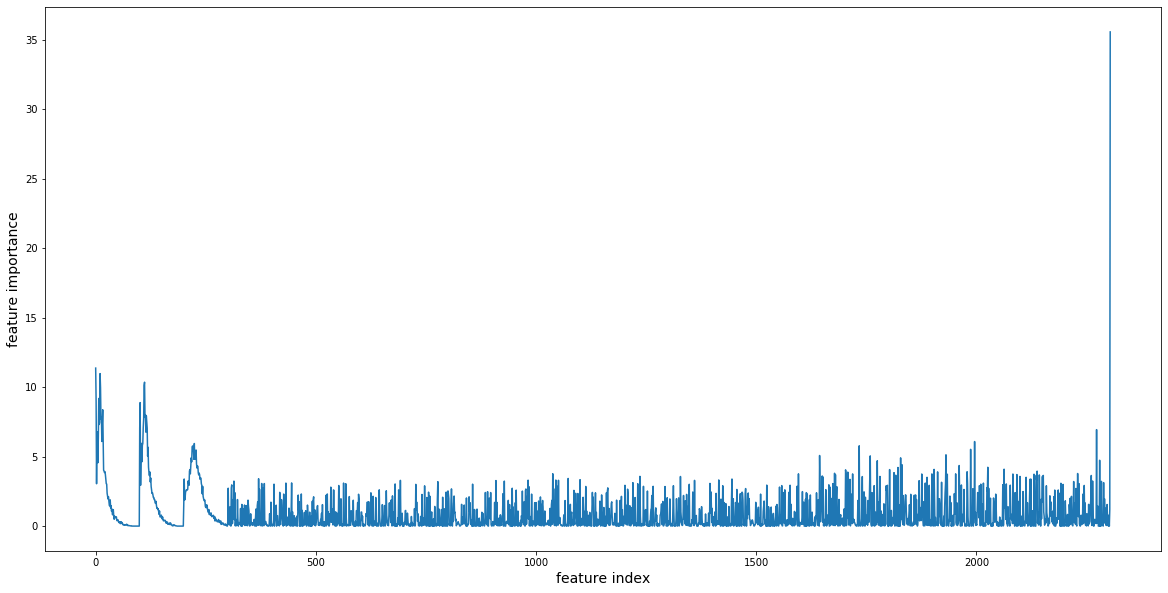

In [178]:
plt.figure(num=None, figsize=(20,10))
plt.plot(average_fis)
plt.xlabel('feature index', fontsize=14)
plt.ylabel('feature importance', fontsize=14)
plt.savefig('cn_full_ct_fis.png', dpi=100)

In [179]:
plt.close()

## Dummy model

In [180]:
# Train model
start_time = time.time()
dummy_model_file = 'dummy_model.joblib'
dummy_clf = train_lgbm_classifier(
    np.zeros((len(y_train), 2)), y_train, dummy_model_file
)
print(f'Training complete. Training time: {time.time()-start_time} s')

# Make predictions with trained model
dummy_preds = dummy_clf.predict_proba(
    np.zeros((len(y_test), 2))
)

# Get top-k predicted rankings from prediction set
dummy_preds_labeled = get_top_k_preds(
    dummy_preds, cutoffs, category_initials, k=3, include_nulls=True
)

# Get labels from ground truth
y_test_labeled = label_ground_truth(
    y_test, cutoffs, category_initials, include_nulls=True
)

# Format results for performance metric calculations
type_count = get_type_count(cutoffs, category_initials)
dummy_formatted_results = format_results_for_metrics(
    dummy_preds_labeled, y_test_labeled, type_count, category_initials
)

# Calculate metrics and save results file
dummy_metrics = get_metrics_dict(
    dummy_formatted_results, type_count, 'dummy_metrics.json'
)

# View top-1 and top-3 accuracy metrics
dummy_top_1_acc = dummy_metrics['top_1_acc']
dummy_top_3_acc = dummy_metrics['top_k_acc']

/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 128 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 129 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 130 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 139 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 150 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all tr

Training complete. Training time: 10.555411100387573 s
Top 1 accuracy for type  M  : 0.24874651810584958
Top 3 accuracy for type  M  : 0.6534818941504178
Top 1 accuracy for type  L  : 0.5284122562674095
Top 3 accuracy for type  L  : 0.6671309192200557
Top 1 accuracy for type  B  : 0.2434540389972145
Top 3 accuracy for type  B  : 0.6373259052924791
Top 1 accuracy for type  S  : 0.3172701949860724
Top 3 accuracy for type  S  : 0.5548746518105849
Top 1 accuracy for type  A  : 0.8894150417827298
Top 3 accuracy for type  A  : 0.9142061281337047
